In [194]:
import pandas as pd
import numpy as np
import pdb
from tqdm import tqdm
from collections import Counter, defaultdict
import json

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

In [2]:
diags_mimic = pd.read_csv('./physionet.org/files/mimiciv/2.2/hosp/diagnoses_icd.csv.gz')
diags_mimic

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
4756321,19999987,23865745,7,41401,9
4756322,19999987,23865745,8,78039,9
4756323,19999987,23865745,9,0413,9
4756324,19999987,23865745,10,36846,9


In [3]:
icd_codes_csv = pd.read_csv('./physionet.org/files/mimiciv/2.2/hosp/d_icd_diagnoses.csv.gz')
icd_codes_csv

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A
...,...,...,...
109770,Z992,10,Dependence on renal dialysis
109771,Z993,10,Dependence on wheelchair
109772,Z998,10,Dependence on other enabling machines and devices
109773,Z9981,10,Dependence on supplemental oxygen


In [4]:
# pneumonia_patients = diags_mimic[((diags_mimic['icd_code']=='4957') & (diags_mimic['icd_version']==9))
#                                  | ((diags_mimic['icd_code']=='99731') & (diags_mimic['icd_version']==9))
#                                  | ((diags_mimic['icd_code']=='J95851') & (diags_mimic['icd_version']==10))]
pneumonia_patients = diags_mimic[(diags_mimic['icd_code']=='486') & (diags_mimic['icd_version']==9)]
pneumonia_patients

,subject_id,hadm_id,seq_num,icd_code,icd_version
114,10000826,20032235,2,486,9
725,10001884,25758848,1,486,9
1160,10002155,20345487,2,486,9
1179,10002155,23822395,2,486,9
1203,10002155,28976727,1,486,9
...,...,...,...,...,...
4755852,19998878,27930413,2,486,9
4755872,19998878,29356037,2,486,9
4755957,19999287,22997012,2,486,9
4756069,19999625,25304202,1,486,9


In [11]:
# 8547 pneumonia patients
pneumonia_patient_ids = list(set(list(pneumonia_patients['subject_id'])))

In [5]:
chartevents = pd.read_csv('./physionet.org/files/mimiciv/2.2/icu/chartevents.csv.gz')

In [12]:
chartevents_no_label = chartevents[chartevents['subject_id'].isin(pneumonia_patient_ids)]
chartevents_no_label

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
4644,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226707,62,62.0,Inch,0.0
4645,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226730,157,157.0,cm,0.0
4646,10001884,26184834,37510196,3512.0,2131-01-13 14:43:00,2131-01-13 14:43:00,226531,143,143.0,NaN,0.0
4647,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224080,30 Degrees,NaN,NaN,0.0
4648,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224086,Good,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
313633790,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,225624,48,48.0,mg/dL,1.0
313633791,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227073,13,13.0,mEq/L,0.0
313633792,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227442,4.3,4.3,mEq/L,0.0
313633793,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227443,21,21.0,mEq/L,1.0


In [14]:
item_info = pd.read_csv('./physionet.org/files/mimiciv/2.2/icu/d_items.csv.gz')
item_info

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220001,Problem List,Problem List,chartevents,General,NaN,Text,NaN,NaN
1,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4009,230077,Documented on DC Summary (PICC),Documented on DC Summary (PICC),chartevents,PICC Line Insertion,NaN,Text,NaN,NaN
4010,230078,Documented on DC Summary (Thora),Documented on DC Summary (Thora),chartevents,Thoracentesis,NaN,Text,NaN,NaN
4011,230083,Replacement Fluid (Pre-Filter),Replacement Fluid (Pre-Filter),chartevents,Dialysis,NaN,Text,NaN,NaN
4012,230084,Replacement Fluid (Post-Filter),Replacement Fluid (Post-Filter),chartevents,Dialysis,NaN,Text,NaN,NaN


In [19]:
# make item id to item label/name dictionary
item_dict = {}
for _, row in tqdm(item_info.iterrows(), total=len(item_info), desc="Processing rows"):
    id = int(row['itemid'])
    item_dict[id] = row['label']

item_dict

Processing rows: 100%|██████████| 4014/4014 [00:00<00:00, 49796.17it/s]


{220001: 'Problem List',
 220003: 'ICU Admission date',
 220045: 'Heart Rate',
 220046: 'Heart rate Alarm - High',
 220047: 'Heart Rate Alarm - Low',
 220048: 'Heart Rhythm',
 220050: 'Arterial Blood Pressure systolic',
 220051: 'Arterial Blood Pressure diastolic',
 220052: 'Arterial Blood Pressure mean',
 220056: 'Arterial Blood Pressure Alarm - Low',
 220058: 'Arterial Blood Pressure Alarm - High',
 220059: 'Pulmonary Artery Pressure systolic',
 220060: 'Pulmonary Artery Pressure diastolic',
 220061: 'Pulmonary Artery Pressure mean',
 220063: 'Pulmonary Artery Pressure Alarm - High',
 220066: 'Pulmonary Artery Pressure Alarm - Low',
 220069: 'Left Artrial Pressure',
 220072: 'Central Venous Pressure Alarm - High',
 220073: 'Central Venous Pressure  Alarm - Low',
 220074: 'Central Venous Pressure',
 220088: 'Cardiac Output (thermodilution)',
 220120: 'Intra Aortic Ballon Pump Setting',
 220125: 'Left Ventricular Assit Device Flow',
 220128: 'Right Ventricular Assist Device Flow',
 220

In [20]:
item_name_list = []
for _, row in tqdm(chartevents_no_label.iterrows(), total=len(chartevents_no_label), desc="Processing rows"):
    item_id = int(row['itemid'])
    item_name = item_dict[item_id]
    item_name_list.append(item_name)

chartevents_no_label['item_name'] = item_name_list

Processing rows: 100%|██████████| 53431321/53431321 [16:26<00:00, 54181.26it/s]
/var/folders/rn/scy6ltdn1374gwc_l7grnh1w0000gp/T/ipykernel_17807/4279683916.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chartevents_no_label['item_name'] = item_name_list


In [21]:
chartevents_no_label

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,item_name
4644,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226707,62,62.0,Inch,0.0,Height
4645,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226730,157,157.0,cm,0.0,Height (cm)
4646,10001884,26184834,37510196,3512.0,2131-01-13 14:43:00,2131-01-13 14:43:00,226531,143,143.0,NaN,0.0,Admission Weight (lbs.)
4647,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224080,30 Degrees,NaN,NaN,0.0,Head of Bed
4648,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224086,Good,NaN,NaN,0.0,Activity Tolerance
...,...,...,...,...,...,...,...,...,...,...,...,...
313633790,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,225624,48,48.0,mg/dL,1.0,BUN
313633791,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227073,13,13.0,mEq/L,0.0,Anion gap
313633792,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum)
313633793,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227443,21,21.0,mEq/L,1.0,HCO3 (serum)


# Add column in emars chart time that only looks at hours

In [101]:
emars = pd.read_csv('./physionet.org/files/mimiciv/2.2/hosp/emar.csv.gz')
emars

,subject_id,hadm_id,emar_id,emar_seq,poe_id,pharmacy_id,enter_provider_id,charttime,medication,event_txt,scheduletime,storetime
0,10000032,22595853.0,10000032-10,10,10000032-36,48770010.0,NaN,2180-05-07 00:44:00,Potassium Chloride,Administered,2180-05-07 00:44:00,2180-05-07 00:44:00
1,10000032,22595853.0,10000032-11,11,10000032-22,14779570.0,NaN,2180-05-07 00:44:00,Sodium Chloride 0.9% Flush,Flushed,2180-05-07 00:44:00,2180-05-07 00:44:00
2,10000032,22595853.0,10000032-12,12,10000032-37,93463122.0,NaN,2180-05-07 06:10:00,Ipratropium Bromide Neb,Administered,2180-05-07 06:00:00,2180-05-07 06:10:00
3,10000032,22595853.0,10000032-13,13,10000032-28,42497745.0,NaN,2180-05-07 05:00:00,Albuterol Inhaler,Administered,2180-05-07 06:29:00,2180-05-07 06:29:00
4,10000032,22595853.0,10000032-14,14,10000032-29,69131933.0,NaN,2180-05-07 07:51:00,Emtricitabine-Tenofovir (Truvada),Administered,2180-05-07 08:00:00,2180-05-07 07:56:00
...,...,...,...,...,...,...,...,...,...,...,...,...
26850354,19999828,NaN,19999828-4,4,19999828-15,NaN,NaN,2147-07-17 18:39:00,Morphine Sulfate,Administered,2147-07-17 18:39:00,2147-07-17 18:40:00
26850355,19999828,NaN,19999828-5,5,19999828-18,NaN,NaN,2147-07-17 18:39:00,NaN,Started,2147-07-17 18:39:00,2147-07-17 18:40:00
26850356,19999828,NaN,19999828-6,6,19999828-16,NaN,NaN,2147-07-17 18:39:00,Ondansetron,Administered,2147-07-17 18:39:00,2147-07-17 18:40:00
26850357,19999828,NaN,19999828-7,7,19999828-18,NaN,NaN,2147-07-17 20:50:00,NaN,Stopped,2147-07-17 20:50:00,2147-07-17 20:50:00


In [22]:
chartevents_no_label.rename(columns={'charttime': 'charttime_icu'}, inplace=True)
chartevents_no_label.rename(columns={'storetime': 'storetime_icu'}, inplace=True)
chartevents_no_label.rename(columns={'hadm_id': 'hadm_id_icu'}, inplace=True)

chartevents_no_label

,subject_id,hadm_id_icu,stay_id,caregiver_id,charttime_icu,storetime_icu,itemid,value,valuenum,valueuom,warning,item_name
0,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226707,62,62.0,Inch,0.0,Height
1,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226730,157,157.0,cm,0.0,Height (cm)
2,10001884,26184834,37510196,3512.0,2131-01-13 14:43:00,2131-01-13 14:43:00,226531,143,143.0,NaN,0.0,Admission Weight (lbs.)
3,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224080,30 Degrees,NaN,NaN,0.0,Head of Bed
4,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224086,Good,NaN,NaN,0.0,Activity Tolerance
...,...,...,...,...,...,...,...,...,...,...,...,...
53431316,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,225624,48,48.0,mg/dL,1.0,BUN
53431317,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227073,13,13.0,mEq/L,0.0,Anion gap
53431318,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum)
53431319,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227443,21,21.0,mEq/L,1.0,HCO3 (serum)


In [32]:
# change charttime in chartevents_no_label to only be date + hour
chart_dates_icu = []
for _, row in tqdm(chartevents_no_label.iterrows(), total=len(chartevents_no_label), desc="Processing rows"):
    chart_date = row['charttime_icu'].split()[0]
    chart_hour = (row['charttime_icu'].split()[1]).split(':')[0] + ':00:00'
    chart_dates_icu.append(str(chart_date) + ' ' + str(chart_hour))

chartevents_no_label['charttime_icu_hour'] = chart_dates_icu

chartevents_no_label

Processing rows: 100%|██████████| 53431321/53431321 [17:56<00:00, 49649.83it/s]


,subject_id,hadm_id_icu,stay_id,caregiver_id,charttime_icu,storetime_icu,itemid,value,valuenum,valueuom,warning,item_name,charttime_icu_hour
0,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226707,62,62.0,Inch,0.0,Height,2131-01-11 04:00:00
1,10001884,26184834,37510196,3512.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226730,157,157.0,cm,0.0,Height (cm),2131-01-11 04:00:00
2,10001884,26184834,37510196,3512.0,2131-01-13 14:43:00,2131-01-13 14:43:00,226531,143,143.0,NaN,0.0,Admission Weight (lbs.),2131-01-13 14:00:00
3,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224080,30 Degrees,NaN,NaN,0.0,Head of Bed,2131-01-18 09:00:00
4,10001884,26184834,37510196,4827.0,2131-01-18 09:36:00,2131-01-18 09:38:00,224086,Good,NaN,NaN,0.0,Activity Tolerance,2131-01-18 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53431316,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,225624,48,48.0,mg/dL,1.0,BUN,2139-10-11 14:00:00
53431317,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227073,13,13.0,mEq/L,0.0,Anion gap,2139-10-11 14:00:00
53431318,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum),2139-10-11 14:00:00
53431319,19999625,25304202,31070865,NaN,2139-10-11 14:55:00,2139-10-11 16:03:00,227443,21,21.0,mEq/L,1.0,HCO3 (serum),2139-10-11 14:00:00


# Filter chartevents for features of interest

In [94]:
# dictionary of frequency of each ICU vital
from collections import Counter

list_of_features = list(chartevents_no_label['item_name'])
freq_features = Counter(list_of_features)
freq_features = dict(sorted(freq_features.items(), key=lambda item: item[1], reverse=True))
freq_features

{'Safety Measures': 1354850,
 'Heart Rate': 1153591,
 'Respiratory Rate': 1146926,
 'O2 saturation pulseoxymetry': 1133322,
 'Heart Rhythm': 1069433,
 'Ectopy Type 1': 963242,
 'Non Invasive Blood Pressure mean': 753708,
 'Non Invasive Blood Pressure systolic': 752852,
 'Non Invasive Blood Pressure diastolic': 752634,
 'Less Restrictive Measures': 507598,
 'Head of Bed': 423899,
 'Turn': 420297,
 'Activity Tolerance': 402953,
 'Pain Management': 397555,
 'Position': 391840,
 'Arterial Blood Pressure mean': 382343,
 'Arterial Blood Pressure systolic': 380713,
 'Arterial Blood Pressure diastolic': 380644,
 'Activity': 358798,
 'Temperature Site': 314253,
 'Therapeutic Bed': 302685,
 'Pain Present': 282277,
 'O2 Delivery Device(s)': 281532,
 'Pain Assessment Method': 280625,
 'Temperature Fahrenheit': 277516,
 'RLL Lung Sounds': 275128,
 'RUL Lung Sounds': 275029,
 'LUL Lung Sounds': 274377,
 'LLL Lung Sounds': 273936,
 'Altered Respiratory Status NCP - Interventions': 272300,
 'Alarms On

# Features to include:
- Creatinine (serum)
- Inspired O2 Fraction
- Urine output_ApacheIV
- ALT
- AST
- Arterial Blood Pressure mean
- Arterial Blood Pressure diastolic
- Arterial Blood Pressure systolic
- GcsScore_ApacheIV
- Arterial O2 pressure
- Heart Rate
- Temperature Celsius
- Respiratory Rate
- O2 saturation pulseoxymetry

In [35]:
features_included = ['Creatinine (serum)', 'Inspired O2 Fraction', 'Urine output_ApacheIV', 'ALT', 'AST', 'Arterial Blood Pressure mean',
                     'Arterial Blood Pressure diastolic', 'Arterial Blood Pressure systolic', 'GcsScore_ApacheIV', 'Arterial O2 pressure',
                     'Heart Rate', 'Temperature Celsius', 'Respiratory Rate', 'O2 saturation pulseoxymetry']

In [36]:
chartevents_no_label = chartevents_no_label[chartevents_no_label['item_name'].isin(features_included)]
chartevents_no_label

,subject_id,hadm_id_icu,stay_id,caregiver_id,charttime_icu,storetime_icu,itemid,value,valuenum,valueuom,warning,item_name,charttime_icu_hour
8,10001884,26184834,37510196,10221.0,2131-01-18 19:00:00,2131-01-18 21:05:00,220045,69,69.0,bpm,0.0,Heart Rate,2131-01-18 19:00:00
10,10001884,26184834,37510196,10221.0,2131-01-18 19:00:00,2131-01-18 21:05:00,220210,17,17.0,insp/min,0.0,Respiratory Rate,2131-01-18 19:00:00
15,10001884,26184834,37510196,10221.0,2131-01-18 19:04:00,2131-01-18 21:05:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,2131-01-18 19:00:00
21,10001884,26184834,37510196,10221.0,2131-01-18 20:00:00,2131-01-18 21:05:00,220045,70,70.0,bpm,0.0,Heart Rate,2131-01-18 20:00:00
23,10001884,26184834,37510196,10221.0,2131-01-18 20:00:00,2131-01-18 21:05:00,220210,16,16.0,insp/min,0.0,Respiratory Rate,2131-01-18 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53431269,19999625,25304202,31070865,84925.0,2139-10-11 06:00:00,2139-10-11 06:20:00,220210,16,16.0,insp/min,0.0,Respiratory Rate,2139-10-11 06:00:00
53431270,19999625,25304202,31070865,84925.0,2139-10-11 06:00:00,2139-10-11 06:20:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,2139-10-11 06:00:00
53431273,19999625,25304202,31070865,NaN,2139-10-10 23:25:00,2139-10-11 00:23:00,220615,2.5,2.5,mg/dL,1.0,Creatinine (serum),2139-10-10 23:00:00
53431297,19999625,25304202,31070865,NaN,2139-10-11 04:21:00,2139-10-11 05:26:00,220615,2.3,2.3,mg/dL,1.0,Creatinine (serum),2139-10-11 04:00:00


In [39]:
# create time_hour : stay_id list dict
time_stay_mapping = defaultdict(set) 

for _, row in tqdm(chartevents_no_label.iterrows(), total=len(chartevents_no_label), desc="Processing rows"):
    key = (row['charttime_icu_hour'],row['subject_id'])
    time_stay_mapping[key].add(row['stay_id'])
for key in time_stay_mapping:
    if len(time_stay_mapping[key]) > 1:
        print('key: ', key, time_stay_mapping[key])

Processing rows: 100%|██████████| 4950559/4950559 [01:42<00:00, 48407.51it/s]


key:  ('2144-04-11 17:00:00', 10004401) {31202136, 38292466}
key:  ('2144-04-12 01:00:00', 10004401) {31202136, 38292466}
key:  ('2144-04-12 20:00:00', 10004401) {31202136, 38292466}
key:  ('2144-04-13 04:00:00', 10004401) {31202136, 38292466}
key:  ('2201-07-10 10:00:00', 10026255) {38229329, 31248398}
key:  ('2127-09-25 18:00:00', 10132888) {31822561, 34165381}
key:  ('2137-01-06 17:00:00', 10184327) {35730582, 34699095}
key:  ('2166-11-05 14:00:00', 10213338) {33505376, 37716614}
key:  ('2166-01-12 18:00:00', 10213338) {31091474, 38416275}
key:  ('2119-02-22 12:00:00', 10254774) {38236413, 33346110}
key:  ('2150-09-28 08:00:00', 10258162) {38570280, 38308794}
key:  ('2147-01-14 10:00:00', 10286475) {31517398, 31116006}
key:  ('2142-01-22 17:00:00', 10298890) {30074165, 30786854}
key:  ('2161-12-24 07:00:00', 10311506) {33804680, 36022337}
key:  ('2142-05-14 20:00:00', 10350488) {36592635, 36891438}
key:  ('2172-12-14 04:00:00', 10364180) {34056688, 38152053}
key:  ('2172-12-15 06:00

In [63]:
n = len(time_stay_mapping)
count = 0
key_list = list(time_stay_mapping.keys())
for key in key_list:
    if len(time_stay_mapping[key]) > 1:
        count +=1
        del time_stay_mapping[key]

print(len(key_list))
print("multiple stsy id: ", count)
assert len(time_stay_mapping) == n-count


1054402
multiple stsy id:  742


In [40]:
meds = {
    'Metroprolol Tartrate': '1',
    'Azithromycin': '2',
    'Hydrocortisone Na Succ.': '3',
    'Ipratropium Bromide Neb': '3',
    'Ipratropium-Albuterol Neb': '3',
    'Albuterol 0.083% Neb Soln': '4',
    'Gabapentin': '5'
}

In [102]:
# filter emars.csv for the 5 medications we care about for pneumonia

# emars_pneumonia = emars[emars['medication'].apply(lambda x: x in meds.keys())]
emars_pneumonia = emars
icu_subjects = list(set(list(chartevents_no_label['subject_id'])))

# only look at patients that appear in the icu chartevents.csv
emars_pneumonia = emars_pneumonia[emars_pneumonia['subject_id'].apply(lambda x: int(x) in icu_subjects)] # 96738 subject_ids, with repeats

emars_pneumonia.rename(columns={'charttime': 'charttime_emars'}, inplace=True)
emars_pneumonia.rename(columns={'storetime': 'storetime_emars'}, inplace=True)
emars_pneumonia.rename(columns={'hadm_id': 'hadm_id_emars'}, inplace=True)

emars_pneumonia

KeyboardInterrupt: 

In [44]:
# change charttime in emars_pneumonia to only be date + hour
chart_dates_emar = []
for _, row in tqdm(emars_pneumonia.iterrows(), total=len(emars_pneumonia), desc="Processing rows"):
    chart_date = row['charttime_emars'].split()[0]
    chart_hour = (row['charttime_emars'].split()[1]).split(':')[0] + ':00:00'
    chart_dates_emar.append(str(chart_date) + ' ' + str(chart_hour))

emars_pneumonia['charttime_emars_hour'] = chart_dates_emar

emars_pneumonia.to_pickle('medication_pneumonia_by_hour.pkl')

Processing rows: 100%|██████████| 1923655/1923655 [00:37<00:00, 51113.80it/s]
/var/folders/rn/scy6ltdn1374gwc_l7grnh1w0000gp/T/ipykernel_33037/3609021968.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emars_pneumonia['charttime_emars_hour'] = chart_dates_emar


# Combine measurements (ICU) and medications (hosp)

In [43]:
grouped_emars_pneumonia = emars_pneumonia.groupby('subject_id').agg(list)
grouped_chartevents_icu = chartevents_no_label.groupby('subject_id').agg(list)

In [44]:
combo_df_grouped = pd.merge(grouped_emars_pneumonia, grouped_chartevents_icu, on='subject_id', how='inner')

combo_df_grouped

,hadm_id_emars,emar_id,emar_seq,poe_id,pharmacy_id,enter_provider_id,charttime_emars,medication,event_txt,scheduletime,...,caregiver_id,charttime_icu,storetime_icu,itemid,value,valuenum,valueuom,warning,item_name,charttime_icu_hour
subject_id,,,,,,,,,,,,,,,,,,,,,
10001884,"[21192799.0, 21192799.0, 21192799.0, 21192799....","[10001884-293, 10001884-294, 10001884-297, 100...","[293, 294, 297, 298, 299, 301, 320, 527, 528, ...","[10001884-909, 10001884-910, 10001884-909, 100...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2130-10-05 16:59:00, 2130-10-05 16:59:00, 213...","[Albuterol 0.083% Neb Soln, Ipratropium Bromid...","[Administered, Administered, Administered, Adm...","[2130-10-05 16:59:00, 2130-10-05 16:59:00, 213...",...,"[10221.0, 10221.0, 10221.0, 10221.0, 10221.0, ...","[2131-01-18 19:00:00, 2131-01-18 19:00:00, 213...","[2131-01-18 21:05:00, 2131-01-18 21:05:00, 213...","[220045, 220210, 220277, 220045, 220210, 22027...","[69, 17, 100, 70, 16, 100, 72, 15, 92, 65, 13,...","[69.0, 17.0, 100.0, 70.0, 16.0, 100.0, 72.0, 1...","[bpm, insp/min, %, bpm, insp/min, %, bpm, insp...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Heart Rate, Respiratory Rate, O2 saturation p...","[2131-01-18 19:00:00, 2131-01-18 19:00:00, 213..."
10013643,"[20023045.0, 20023045.0, 20023045.0, 20023045....","[10013643-140, 10013643-144, 10013643-169, 100...","[140, 144, 169, 195, 208, 228, 250]","[10013643-574, 10013643-557, 10013643-557, 100...","[14462514.0, 84109470.0, 84109470.0, 84109470....","[nan, P26JJS, P26JJS, nan, nan, nan, nan]","[2200-10-26 01:40:00, 2200-10-26 09:16:00, 220...","[Albuterol 0.083% Neb Soln, Gabapentin, Gabape...","[Administered, Administered, Administered, Adm...","[2200-10-26 01:40:00, 2200-10-26 08:00:00, 220...",...,"[10759.0, 10759.0, 10759.0, 10759.0, 10759.0, ...","[2200-10-01 11:35:00, 2200-10-01 11:44:00, 220...","[2200-10-01 11:50:00, 2200-10-01 11:50:00, 220...","[223835, 220277, 223835, 223835, 220277, 22004...","[100, 100, 50, 50, 98, 60, 104, 49, 67, 18, 97...","[100.0, 100.0, 50.0, 50.0, 98.0, 60.0, 104.0, ...","[nan, %, nan, nan, %, bpm, mmHg, mmHg, mmHg, i...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Inspired O2 Fraction, O2 saturation pulseoxym...","[2200-10-01 11:00:00, 2200-10-01 11:00:00, 220..."
10021927,"[22659276.0, 23785565.0, 23785565.0, 23785565....","[10021927-155, 10021927-15, 10021927-27, 10021...","[155, 15, 27, 46, 72, 90, 93, 504, 514, 498]","[10021927-952, 10021927-821, 10021927-821, 100...","[16814126.0, 53629663.0, 53629663.0, 53629663....","[nan, nan, nan, nan, nan, nan, nan, nan, P57P3...","[2179-02-04 12:04:00, 2179-01-25 20:45:00, 217...","[Ipratropium Bromide Neb, Ipratropium Bromide ...","[Administered, Administered, Administered, Adm...","[2179-02-04 12:04:00, 2179-01-25 20:45:00, 217...",...,"[1616.0, 1616.0, 1616.0, 1616.0, 6579.0, 6579....","[2179-01-18 09:00:00, 2179-01-18 10:00:00, 217...","[2179-01-18 09:23:00, 2179-01-18 11:34:00, 217...","[223835, 223835, 223835, 223835, 223835, 22383...","[85, 100, 50, 95, 50, 50, 50, 95, 120, 24, 100...","[85.0, 100.0, 50.0, 95.0, 50.0, 50.0, 50.0, 95...","[nan, nan, nan, nan, nan, nan, nan, %, bpm, in...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Inspired O2 Fraction, Inspired O2 Fraction, I...","[2179-01-18 09:00:00, 2179-01-18 10:00:00, 217..."
10035631,"[29276678.0, 29276678.0, 29276678.0]","[10035631-793, 10035631-794, 10035631-836]","[793, 794, 836]","[10035631-1262, 10035631-1272, 10035631-1299]","[73779951.0, 93003823.0, 73779951.0]","[nan, nan, nan]","[2116-02-28 10:20:00, 2116-02-28 10:22:00, 211...","[Albuterol 0.083% Neb Soln, Ipratropium-Albute...","[Not Given, Administered, Administered]","[2116-02-28 10:20:00, 2116-02-28 10:21:00, 211...",...,"[8034.0, 8034.0, 8034.0, 8034.0, 8034.0, 8034....","[2116-02-29 19:00:00, 2116-02-29 19:00:00, 211...","[2116-03-01 00:10:00, 2116-03-01 00:10:00, 211...","[220045, 220210, 220277, 2200

In [45]:
combo_df_grouped.to_pickle('pneumonia_chartevents_and_medications_grouped_by_subjects_and_stay_ids.pkl')

# Create Non-Imputed DataFrame

In [46]:
combo_df_grouped = pd.read_pickle('pneumonia_chartevents_and_medications_grouped_by_subjects_and_stay_ids.pkl')

In [47]:
# check if there are any subject_ids that have overlap between emar_time_hour and charttime_icu_hour
good_subjects = []

for _, row in tqdm(combo_df_grouped.iterrows(), total=len(combo_df_grouped), desc="Processing rows"):
    emars_hours = set(row['charttime_emars_hour'])
    icu_hours = set(row['charttime_icu_hour'])

    if not emars_hours.isdisjoint(icu_hours):
        good_subjects.append(row.name)

good_subjects

Processing rows: 100%|██████████| 1559/1559 [00:01<00:00, 902.05it/s] 


[10001884,
 10021927,
 10035631,
 10051043,
 10078805,
 10085784,
 10108435,
 10111136,
 10161112,
 10207476,
 10213338,
 10233088,
 10254774,
 10263098,
 10364180,
 10373824,
 10380616,
 10386233,
 10387377,
 10404360,
 10497097,
 10501162,
 10520715,
 10551762,
 10576646,
 10585182,
 10594674,
 10606611,
 10610928,
 10613328,
 10627556,
 10637168,
 10674538,
 10702059,
 10717732,
 10724345,
 10749008,
 10751641,
 10833257,
 10839295,
 10850048,
 10896351,
 10901772,
 10904848,
 10912090,
 10913302,
 10921049,
 10922531,
 10930322,
 10942097,
 10942537,
 10946740,
 10979912,
 11044484,
 11052273,
 11079785,
 11106524,
 11158097,
 11178609,
 11191438,
 11245751,
 11292424,
 11303674,
 11355855,
 11372027,
 11407375,
 11411718,
 11413236,
 11437366,
 11441519,
 11454901,
 11474065,
 11532659,
 11542052,
 11576109,
 11630846,
 11634090,
 11658675,
 11676232,
 11714071,
 11717909,
 11725800,
 11739489,
 11770833,
 11789279,
 11793360,
 11812613,
 11818101,
 11865363,
 11868667,
 11885477,

In [48]:
len(good_subjects) # 477 patients have emar time and icu time intersection

477

In [49]:
# only get those 477 patients
combo_df_grouped_traj = combo_df_grouped[combo_df_grouped.index.isin(good_subjects)]
combo_df_grouped_traj.to_pickle('pneumonia_chartevents_and_medications_grouped_by_subjects_and_stay_ids_477.pkl')

In [50]:
combo_df_grouped_traj = pd.read_pickle('pneumonia_chartevents_and_medications_grouped_by_subjects_and_stay_ids_477.pkl')
combo_df_grouped_traj

,hadm_id_emars,emar_id,emar_seq,poe_id,pharmacy_id,enter_provider_id,charttime_emars,medication,event_txt,scheduletime,...,caregiver_id,charttime_icu,storetime_icu,itemid,value,valuenum,valueuom,warning,item_name,charttime_icu_hour
subject_id,,,,,,,,,,,,,,,,,,,,,
10001884,"[21192799.0, 21192799.0, 21192799.0, 21192799....","[10001884-293, 10001884-294, 10001884-297, 100...","[293, 294, 297, 298, 299, 301, 320, 527, 528, ...","[10001884-909, 10001884-910, 10001884-909, 100...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2130-10-05 16:59:00, 2130-10-05 16:59:00, 213...","[Albuterol 0.083% Neb Soln, Ipratropium Bromid...","[Administered, Administered, Administered, Adm...","[2130-10-05 16:59:00, 2130-10-05 16:59:00, 213...",...,"[10221.0, 10221.0, 10221.0, 10221.0, 10221.0, ...","[2131-01-18 19:00:00, 2131-01-18 19:00:00, 213...","[2131-01-18 21:05:00, 2131-01-18 21:05:00, 213...","[220045, 220210, 220277, 220045, 220210, 22027...","[69, 17, 100, 70, 16, 100, 72, 15, 92, 65, 13,...","[69.0, 17.0, 100.0, 70.0, 16.0, 100.0, 72.0, 1...","[bpm, insp/min, %, bpm, insp/min, %, bpm, insp...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Heart Rate, Respiratory Rate, O2 saturation p...","[2131-01-18 19:00:00, 2131-01-18 19:00:00, 213..."
10021927,"[22659276.0, 23785565.0, 23785565.0, 23785565....","[10021927-155, 10021927-15, 10021927-27, 10021...","[155, 15, 27, 46, 72, 90, 93, 504, 514, 498]","[10021927-952, 10021927-821, 10021927-821, 100...","[16814126.0, 53629663.0, 53629663.0, 53629663....","[nan, nan, nan, nan, nan, nan, nan, nan, P57P3...","[2179-02-04 12:04:00, 2179-01-25 20:45:00, 217...","[Ipratropium Bromide Neb, Ipratropium Bromide ...","[Administered, Administered, Administered, Adm...","[2179-02-04 12:04:00, 2179-01-25 20:45:00, 217...",...,"[1616.0, 1616.0, 1616.0, 1616.0, 6579.0, 6579....","[2179-01-18 09:00:00, 2179-01-18 10:00:00, 217...","[2179-01-18 09:23:00, 2179-01-18 11:34:00, 217...","[223835, 223835, 223835, 223835, 223835, 22383...","[85, 100, 50, 95, 50, 50, 50, 95, 120, 24, 100...","[85.0, 100.0, 50.0, 95.0, 50.0, 50.0, 50.0, 95...","[nan, nan, nan, nan, nan, nan, nan, %, bpm, in...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Inspired O2 Fraction, Inspired O2 Fraction, I...","[2179-01-18 09:00:00, 2179-01-18 10:00:00, 217..."
10035631,"[29276678.0, 29276678.0, 29276678.0]","[10035631-793, 10035631-794, 10035631-836]","[793, 794, 836]","[10035631-1262, 10035631-1272, 10035631-1299]","[73779951.0, 93003823.0, 73779951.0]","[nan, nan, nan]","[2116-02-28 10:20:00, 2116-02-28 10:22:00, 211...","[Albuterol 0.083% Neb Soln, Ipratropium-Albute...","[Not Given, Administered, Administered]","[2116-02-28 10:20:00, 2116-02-28 10:21:00, 211...",...,"[8034.0, 8034.0, 8034.0, 8034.0, 8034.0, 8034....","[2116-02-29 19:00:00, 2116-02-29 19:00:00, 211...","[2116-03-01 00:10:00, 2116-03-01 00:10:00, 211...","[220045, 220210, 220277, 220045, 220210, 22004...","[116, 13, 98, 108, 19, 100, 20, 96, 84, 48, 60...","[116.0, 13.0, 98.0, 108.0, 19.0, 100.0, 20.0, ...","[bpm, insp/min, %, bpm, insp/min, bpm, insp/mi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Heart Rate, Respiratory Rate, O2 saturation p...","[2116-02-29 19:00:00, 2116-02-29 19:00:00, 211..."
10051043,"[22009252.0, 25409423.0]","[10051043-171, 10051043-788]","[171, 788]","[10051043-713, 10051043-1312]","[82496679.0, nan]","[nan, P53XNU]","[2196-10-05 20:38:00, 2197-12-19 09:55:00]","[Ipratropium-Albuterol Neb, Albuterol 0.083% N...","[Administered, Administered]","[2196-10-05 20:38:00, 2197-12-19 09:55:00]",...,"[62254.0, 62254.0, 62254.0, 62254.0, 62254.0, ...","[2196-10-05 19:04:00, 2196-10-05 19:04:00, 219...","[2196-10-05 19:31:00, 2196-10-05 19:31:00, 219...","[220045, 220210, 220277, 220045, 220210, 22027...","[102, 18, 97, 110, 25, 98, 35, 97, 28, 95, 88,...","[102.0, 18.0, 97.0, 110.0, 25.0, 98.0, 35.0, 9...","[bpm, insp/min, %, bpm, insp/min, %, nan, bpm,...","[0.0, 0

In [51]:
del combo_df_grouped_traj['pharmacy_id']
del combo_df_grouped_traj['enter_provider_id']
del combo_df_grouped_traj['caregiver_id']
del combo_df_grouped_traj['valuenum']
del combo_df_grouped_traj['valueuom']
del combo_df_grouped_traj['warning']
del combo_df_grouped_traj['scheduletime']
del combo_df_grouped_traj['storetime_emars']
del combo_df_grouped_traj['storetime_icu']

In [52]:
combo_df_grouped_traj

,hadm_id_emars,emar_id,emar_seq,poe_id,charttime_emars,medication,event_txt,charttime_emars_hour,hadm_id_icu,stay_id,charttime_icu,itemid,value,item_name,charttime_icu_hour
subject_id,,,,,,,,,,,,,,,
10001884,"[21192799.0, 21192799.0, 21192799.0, 21192799....","[10001884-293, 10001884-294, 10001884-297, 100...","[293, 294, 297, 298, 299, 301, 320, 527, 528, ...","[10001884-909, 10001884-910, 10001884-909, 100...","[2130-10-05 16:59:00, 2130-10-05 16:59:00, 213...","[Albuterol 0.083% Neb Soln, Ipratropium Bromid...","[Administered, Administered, Administered, Adm...","[2130-10-05 16:00:00, 2130-10-05 16:00:00, 213...","[26184834, 26184834, 26184834, 26184834, 26184...","[37510196, 37510196, 37510196, 37510196, 37510...","[2131-01-18 19:00:00, 2131-01-18 19:00:00, 213...","[220045, 220210, 220277, 220045, 220210, 22027...","[69, 17, 100, 70, 16, 100, 72, 15, 92, 65, 13,...","[Heart Rate, Respiratory Rate, O2 saturation p...","[2131-01-18 19:00:00, 2131-01-18 19:00:00, 213..."
10021927,"[22659276.0, 23785565.0, 23785565.0, 23785565....","[10021927-155, 10021927-15, 10021927-27, 10021...","[155, 15, 27, 46, 72, 90, 93, 504, 514, 498]","[10021927-952, 10021927-821, 10021927-821, 100...","[2179-02-04 12:04:00, 2179-01-25 20:45:00, 217...","[Ipratropium Bromide Neb, Ipratropium Bromide ...","[Administered, Administered, Administered, Adm...","[2179-02-04 12:00:00, 2179-01-25 20:00:00, 217...","[23785565, 23785565, 23785565, 23785565, 23785...","[39633643, 39633643, 39633643, 39633643, 39633...","[2179-01-18 09:00:00, 2179-01-18 10:00:00, 217...","[223835, 223835, 223835, 223835, 223835, 22383...","[85, 100, 50, 95, 50, 50, 50, 95, 120, 24, 100...","[Inspired O2 Fraction, Inspired O2 Fraction, I...","[2179-01-18 09:00:00, 2179-01-18 10:00:00, 217..."
10035631,"[29276678.0, 29276678.0, 29276678.0]","[10035631-793, 10035631-794, 10035631-836]","[793, 794, 836]","[10035631-1262, 10035631-1272, 10035631-1299]","[2116-02-28 10:20:00, 2116-02-28 10:22:00, 211...","[Albuterol 0.083% Neb Soln, Ipratropium-Albute...","[Not Given, Administered, Administered]","[2116-02-28 10:00:00, 2116-02-28 10:00:00, 211...","[29276678, 29276678, 29276678, 29276678, 29276...","[30932571, 30932571, 30932571, 30932571, 30932...","[2116-02-29 19:00:00, 2116-02-29 19:00:00, 211...","[220045, 220210, 220277, 220045, 220210, 22004...","[116, 13, 98, 108, 19, 100, 20, 96, 84, 48, 60...","[Heart Rate, Respiratory Rate, O2 saturation p...","[2116-02-29 19:00:00, 2116-02-29 19:00:00, 211..."
10051043,"[22009252.0, 25409423.0]","[10051043-171, 10051043-788]","[171, 788]","[10051043-713, 10051043-1312]","[2196-10-05 20:38:00, 2197-12-19 09:55:00]","[Ipratropium-Albuterol Neb, Albuterol 0.083% N...","[Administered, Administered]","[2196-10-05 20:00:00, 2197-12-19 09:00:00]","[22009252, 22009252, 22009252, 22009252, 22009...","[34618905, 34618905, 34618905, 34618905, 34618...","[2196-10-05 19:04:00, 2196-10-05 19:04:00, 219...","[220045, 220210, 220277, 220045, 220210, 22027...","[102, 18, 97, 110, 25, 98, 35, 97, 28, 95, 88,...","[Heart Rate, Respiratory Rate, O2 saturation p...","[2196-10-05 19:00:00, 2196-10-05 19:00:00, 219..."
10078805,"[20434240.0, 20434240.0, 20434240.0, 20434240....","[10078805-111, 10078805-114, 10078805-123, 100...","[111, 114, 123, 136, 166, 168, 24, 36, 40, 53,...","[10078805-356, 10078805-362, 10078805-366, 100...","[2178-07-21 09:30:00, 2178-07-21 09:30:00, 217...","[Azithromycin, Gabapentin, Ipratropium-Albuter...","[Administered, Administered, Not Given, Admini...","[2178-07-21 09:00:00, 2178-07-21 09:00:00, 217...","[20434240, 20434240, 20434240, 20434240, 20434...","[30950523, 30950523, 30950523, 30950523, 30950...","[2178-07-21 16:00:00, 2178-07-21 16:00:00, 217...","[220277, 223835, 220210, 220045, 220277, 22004...","[96, 70, 32, 92, 97, 93, 19, 94, 140, 98, 97, ...","[O2 saturation pulseoxymetry, Inspired O2 Frac...","[2178-07-21 16:00:00, 2178-07-21 16:00:00, 217..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19934

In [57]:
# change format in which vitals are columns
from collections import defaultdict

# initialize dataframe
col_headers = ['subject_id', 'stay_id', 'time_hour'] + features_included + [(key + ' (binary)') for key in list(meds.keys())]
num_features = len(['subject_id', 'stay_id', 'time_hour'] + features_included)
num_meds = len(meds.keys())
df_traj = pd.DataFrame(columns=col_headers)
df_traj_count = defaultdict(int)

# for header in row_headers:
#     df_traj_count[header] = 0

# fill in dataframe
for _, row in tqdm(combo_df_grouped_traj.iterrows(), total=len(combo_df_grouped_traj), desc="Processing rows"):
    subject_id = row.name
    row_emars_hours = row['charttime_emars_hour']
    row_icu_hours = row['charttime_icu_hour']
    overlapping_hours = list(set(row_emars_hours).intersection(set(row_icu_hours)))
    unique_stay_ids = list(set(row['stay_id']))
    skip, total_iters = 0,0
    # for each hour in which both meds and vitals are taken
    for hour in overlapping_hours:
        for stay_id in unique_stay_ids:
            # check whether stay id is valid:
            total_iters +=1
            if (hour, subject_id) not in time_stay_mapping:
                skip +=1
                continue
            else:
                valid_stay_ids = time_stay_mapping[(hour, subject_id)]
                # medications that are given
                meds_indexes = [index for index, value in enumerate(row_emars_hours) if ((value == hour) and (row['event_txt'][index] != 'Not Given'))]
                meds_given = [row['medication'][index] for index in meds_indexes]
                assert len(meds_indexes) == len(meds_given)
                # vitals that are taken
                features_indexes = [index for index, value in enumerate(row_icu_hours) if ((value == hour))]
                features_names = [row['item_name'][index] for index in features_indexes]
                features_measurements = [row['value'][index] for index in features_indexes]
                assert len(features_indexes) == len(features_names) and len(features_names) == len(features_measurements)


                # create an empty row
                new_row = pd.Series([np.nan]*num_features + [0.0]*num_meds, index=df_traj.columns)

                # update dataframe -- meds
                for i in range(len(meds_given)):
                    med = meds_given[i]
                    new_row[med + ' (binary)'] = 1.0
                
                # update dataframe -- features and stay_id
                for j in range(len(features_names)):
                    feature_name = features_names[j]
                    feature_measurement = features_measurements[j]
                    new_row[feature_name] = feature_measurement

                
                # update dataframe -- subject_id and stay_id
                new_row['subject_id'] = (subject_id)
                new_row['stay_id'] = (stay_id)
                new_row['time_hour'] = hour

                # print(new_row)

                # append new row to dataframe
                df_traj = pd.concat([df_traj, pd.DataFrame(new_row).T], ignore_index=True)
    # calculate percentage skipped
    percentage = skip/total_iters
    if percentage > 0.5:
        print("WARNING: ", subject_id, percentage)
        break

Processing rows: 100%|██████████| 477/477 [03:52<00:00,  2.05it/s]


In [62]:
df_traj.to_pickle('pneumonia_preprocessed_table.pkl')

# Impute Values and create data_df and data_no_normalized_df

In [172]:
df_traj = pd.read_pickle('pneumonia_preprocessed_table.pkl')
test_subject = 19991135
# df_traj_test = df_traj[df_traj['subject_id']==test_subject].drop(columns=['subject_id'])
df_traj_test = df_traj
unique_patients = set(df_traj_test['subject_id'])
print("number of patients:", len(unique_patients))
for col in features_included:
    df_traj_test[col]= df_traj_test[col].apply(lambda x: float(x))

number of patients: 477


In [173]:
single_records = []
for person in unique_patients:
    test = df_traj_test[df_traj_test['subject_id']==person].drop(columns=['subject_id'])
    if len(test) ==1:
        single_records.append(person)

# number of unqiue patients: unique_patients = set(df_traj_test['subject_id']) -- 477-23
# delete all rows that have subject id in 

df_traj_test = df_traj_test.drop(df_traj_test[df_traj_test['subject_id'].apply(lambda x: x in single_records)].index)

In [174]:
df_traj_test = df_traj_test.set_index(['stay_id', 'time_hour']).sort_index()
df_traj_test

subject_id  Creatinine (serum)   
stay_id  time_hour                                            
30002521 2162-05-03 10:00:00   13269859                 NaN  \
         2164-02-07 10:00:00   13269859                 NaN   
         2164-02-08 08:00:00   13269859                 NaN   
30011071 2176-08-18 03:00:00   11885477                 NaN   
30020330 2201-02-10 18:00:00   15884351                 NaN   
...                                 ...                 ...   
39986786 2145-02-26 12:00:00   19962126                 NaN   
         2145-02-26 17:00:00   19962126                 NaN   
         2145-02-27 00:00:00   19962126                 NaN   
         2145-02-27 05:00:00   19962126                 NaN   
         2145-02-27 12:00:00   19962126                 NaN   

                              Inspired O2 Fraction  Urine output_ApacheIV   
stay_id  time_hour                                                          
30002521 2162-05-03 10:00:00                   NaN                    NaN  \
         2164-02-07 10:00:00                   NaN                    NaN   
         2164-02-08 08:00:00                   NaN                    NaN   
30011071 2176-08-18 03:00:00                   NaN                    NaN   
30020330 2201-02-10 18:00:00                   NaN                    NaN   
...                                            ...                    ...   
39986786 2145-02-26 12:00:00                   NaN                    NaN   
         2145-02-26 17:00:00                   NaN                    NaN   
         2145-02-27 00:00:00                   NaN                    NaN   
         2145-02-27 05:00:00                   NaN                    NaN   
         2145-02-27 12:00:00                   NaN                    NaN   

                              ALT  AST  Arterial Blood Pressure mean   
stay_id  time_hour                                                     
30002521 2162-05-03 10:00:00  NaN  NaN                           NaN  \
         2164-02-07 10:00:00  NaN  NaN                           NaN   
         2164-02-08 08:00:00  NaN  NaN                           NaN   
30011071 2176-08-18 03:00:00  NaN  NaN                           NaN   
30020330 2201-02-10 18:00:00  NaN  NaN                           NaN   
...                           ...  ...                           ...   
39986786 2145-02-26 12:00:00  NaN  NaN                           NaN   
         2145-02-26 17:00:00  NaN  NaN                           NaN   
         2145-02-27 00:00:00  NaN  NaN                           NaN   
         2145-02-27 05:00:00  NaN  NaN                           NaN   
         2145-02-27 12:00:00  NaN  NaN                           NaN   

                              Arterial Blood Pressure diastolic   
stay_id  time_hour                                                
30002521 2162-05-03 10:00:00                                NaN  \
         2164-02-07 10:00:00                                NaN   
         2164-02-08 08:00:00                                NaN   
30011071 2176-08-18 03:00:00                                NaN   
30020330 2201-02-10 18:00:00                                NaN   
...                                                         ...   
39986786 2145-02-26 12:00:00                                NaN   
         2145-02-26 17:00:00                                NaN   
         2145-02-27 00:00:00                                NaN   
         2145-02-27 05:00:00                                NaN   
         2145-02-27 12:00:00                                NaN   

                              Arterial Blood Pressure systolic   
stay_id  time_hour                                               
30002521 2162-05-03 10:00:00                               NaN  \
         2164-02-07 10:00:00                               NaN   
         2164-02-08 08:00:00                               NaN   
30011071 2176-08-18 03:00:00                               NaN   
30

In [175]:
df_traj_test['action'] = df_traj_test['Gabapentin (binary)'] + df_traj_test['Albuterol 0.083% Neb Soln (binary)']*2 + \
    (df_traj_test['Ipratropium-Albuterol Neb (binary)'].apply(lambda x: int(x)) | df_traj_test['Ipratropium Bromide Neb (binary)'].apply(lambda x: int(x)) | \
     df_traj_test['Hydrocortisone Na Succ. (binary)'].apply(lambda x: int(x)))*4 + df_traj_test['Azithromycin (binary)']*8 + \
     df_traj_test['Metroprolol Tartrate (binary)']*16

In [176]:
num_data = len(df_traj_test)
np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)

In [177]:
all_idx = np.random.permutation(df_traj_test.index.get_level_values(0).unique())
train_df = df_traj_test.loc[all_idx[:int(len(all_idx)*frac[0])]].sort_index()
test_df = df_traj_test.loc[all_idx[int(len(all_idx)*frac[0]):int(len(all_idx)*frac[1])]].sort_index()
valid_df = df_traj_test.loc[all_idx[int(len(all_idx)*frac[1]):]].sort_index()
# print (np.unique(train_df['action'],return_counts=True)[1]*1./len(train_df))
# pickle.dump([train_df, test_df, valid_df], open(data_save_path+'processed_mimic_hyp_2.pkl','wb'))
drop_columns = ['Metroprolol Tartrate (binary)', 'Azithromycin (binary)', 'Hydrocortisone Na Succ. (binary)', \
                'Ipratropium Bromide Neb (binary)', 'Ipratropium-Albuterol Neb (binary)', 'Albuterol 0.083% Neb Soln (binary)', \
                'Gabapentin (binary)']


In [178]:
# for now drop indicators about bolus and vaso
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)
valid_df = valid_df.drop(columns=drop_columns)

#### imputation
impute_table = pd.read_csv('mimic_iv_hypotensive_cut2_impute_table.csv',sep=',',header=0).set_index(['feature'])
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
valid_df = valid_df.fillna(method='ffill')


for f in impute_table.index:
    train_df[f] = train_df[f].fillna(value = impute_table.loc[f].values[0])
    test_df[f] = test_df[f].fillna(value = impute_table.loc[f].values[0])
    valid_df[f] = valid_df[f].fillna(value = impute_table.loc[f].values[0])


data_non_normalized_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).head(num_data).copy()


In [179]:
data_non_normalized_df.head()

subject_id  Creatinine (serum)   
stay_id  time_hour                                             
30002521 2162-05-03 10:00:00    13269859                 1.0  \
         2164-02-07 10:00:00    13269859                 1.0   
         2164-02-08 08:00:00    13269859                 1.0   
30011071 2176-08-18 03:00:00    11885477                 1.0   
30028516 2179-06-28 18:00:00    15517908                 1.0   

                              Inspired O2 Fraction  Urine output_ApacheIV   
stay_id  time_hour                                                          
30002521 2162-05-03 10:00:00                  0.21                   80.0  \
         2164-02-07 10:00:00                  0.21                   80.0   
         2164-02-08 08:00:00                  0.21                   80.0   
30011071 2176-08-18 03:00:00                  0.21                   80.0   
30028516 2179-06-28 18:00:00                  0.21                   80.0   

                               ALT   AST  Arterial Blood Pressure mean   
stay_id  time_hour                                                       
30002521 2162-05-03 10:00:00  34.0  40.0                          77.0  \
         2164-02-07 10:00:00  34.0  40.0                          77.0   
         2164-02-08 08:00:00  34.0  40.0                          77.0   
30011071 2176-08-18 03:00:00  34.0  40.0                          77.0   
30028516 2179-06-28 18:00:00  34.0  40.0                          77.0   

                              Arterial Blood Pressure diastolic   
stay_id  time_hour                                                
30002521 2162-05-03 10:00:00                               59.0  \
         2164-02-07 10:00:00                               59.0   
         2164-02-08 08:00:00                               59.0   
30011071 2176-08-18 03:00:00                               59.0   
30028516 2179-06-28 18:00:00                               59.0   

                              Arterial Blood Pressure systolic   
stay_id  time_hour                                               
30002521 2162-05-03 10:00:00                             118.0  \
         2164-02-07 10:00:00                             118.0   
         2164-02-08 08:00:00                             118.0   
30011071 2176-08-18 03:00:00                             118.0   
30028516 2179-06-28 18:00:00                             118.0   

                              GcsScore_ApacheIV  Arterial O2 pressure   
stay_id  time_hour                                                      
30002521 2162-05-03 10:00:00               11.0                 276.0  \
         2164-02-07 10:00:00               11.0                 276.0   
         2164-02-08 08:00:00               11.0                 276.0   
30011071 2176-08-18 03:00:00               11.0                 276.0   
30028516 2179-06-28 18:00:00               11.0                 276.0   

                              Heart Rate  Temperature Celsius   
stay_id  time_hour                                              
30002521 2162-05-03 10:00:00        86.0                 37.0  \
         2164-02-07 10:00:00        97.0                 37.0   
         2164-02-08 08:00:00        85.0                 37.0   
30011071 2176-08-18 03:00:00        91.0                 37.0   
30028516 2179-06-28 18:00:00        85.0                 37.0   

                              Respiratory Rate  O2 saturation pulseoxymetry   
stay_id  time_hour                                                            
30002521 2162-05-03 10:00:00              19.0                         98.0  \
         2164-02-07 10:00:00              21.0                         96.0   
         2164-02-08 08:00:00              14.0                         98.0   
30011071 2176-08-18 03:00:00              23.0                        100.0   
30028516 2179-06-28 18:00:00              22.0                        100.0   

                              action  
stay_id  time_hour          

In [180]:
#### standard normalization ####
normalize_features = features_included
mu, std = (train_df[normalize_features]).mean().values,(train_df[normalize_features]).std().values

std=[1.0 if x == 0.0 else x for x in std]

train_df[normalize_features] = (train_df[normalize_features] - mu)/std
test_df[normalize_features] = (test_df[normalize_features] - mu)/std
valid_df[normalize_features] = (valid_df[normalize_features] - mu)/std

In [181]:
### create data matrix ####
X_train = train_df.loc[:,train_df.columns!='action']
y_train = train_df['action']

X_test = test_df.loc[:,test_df.columns!='action']
y_test = test_df['action']

X_valid = valid_df.loc[:, valid_df.columns!='action']
y_valid = valid_df['action']

In [182]:
X_df = pd.concat([X_train, X_valid, X_test], axis=0, ignore_index=True).copy()
y_df = pd.concat([y_train, y_valid, y_test], axis=0, ignore_index=True).copy()

In [183]:
data_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).copy()
# data_df = data_df.head(num_data).copy()
# X_df = X_df.head(num_data).copy()
# y_df = y_df.head(num_data).copy()

In [184]:
print(len(data_df))
print(len(X_df))
print(len(y_df))
print(len(data_non_normalized_df))

52909
52909
52909
52909


In [185]:
data_non_normalized_df

subject_id  Creatinine (serum)   
stay_id  time_hour                                             
30002521 2162-05-03 10:00:00    13269859                 1.0  \
         2164-02-07 10:00:00    13269859                 1.0   
         2164-02-08 08:00:00    13269859                 1.0   
30011071 2176-08-18 03:00:00    11885477                 1.0   
30028516 2179-06-28 18:00:00    15517908                 1.0   
...                                  ...                 ...   
39861860 2167-09-16 14:00:00    17826428                 0.9   
         2167-09-16 19:00:00    17826428                 0.9   
         2167-09-17 07:00:00    17826428                 0.9   
         2167-09-17 14:00:00    17826428                 0.9   
39947889 2140-06-02 17:00:00    12638104                 0.9   

                              Inspired O2 Fraction  Urine output_ApacheIV   
stay_id  time_hour                                                          
30002521 2162-05-03 10:00:00                  0.21                   80.0  \
         2164-02-07 10:00:00                  0.21                   80.0   
         2164-02-08 08:00:00                  0.21                   80.0   
30011071 2176-08-18 03:00:00                  0.21                   80.0   
30028516 2179-06-28 18:00:00                  0.21                   80.0   
...                                            ...                    ...   
39861860 2167-09-16 14:00:00                 40.00                   80.0   
         2167-09-16 19:00:00                 40.00                   80.0   
         2167-09-17 07:00:00                 40.00                   80.0   
         2167-09-17 14:00:00                 40.00                   80.0   
39947889 2140-06-02 17:00:00                 40.00                   80.0   

                               ALT   AST  Arterial Blood Pressure mean   
stay_id  time_hour                                                       
30002521 2162-05-03 10:00:00  34.0  40.0                          77.0  \
         2164-02-07 10:00:00  34.0  40.0                          77.0   
         2164-02-08 08:00:00  34.0  40.0                          77.0   
30011071 2176-08-18 03:00:00  34.0  40.0                          77.0   
30028516 2179-06-28 18:00:00  34.0  40.0                          77.0   
...                            ...   ...                           ...   
39861860 2167-09-16 14:00:00  23.0  22.0                          87.0   
         2167-09-16 19:00:00  23.0  22.0                          87.0   
         2167-09-17 07:00:00  23.0  22.0                          87.0   
         2167-09-17 14:00:00  23.0  22.0                          87.0   
39947889 2140-06-02 17:00:00  23.0  22.0                          87.0   

                              Arterial Blood Pressure diastolic   
stay_id  time_hour                                                
30002521 2162-05-03 10:00:00                               59.0  \
         2164-02-07 10:00:00                               59.0   
         2164-02-08 08:00:00                               59.0   
30011071 2176-08-18 03:00:00                               59.0   
30028516 2179-06-28 18:00:00                               59.0   
...                                                         ...   
39861860 2167-09-16 14:00:00                               57.0   
         2167-09-16 19:00:00                               57.0   
         2167-09-17 07:00:00                               57.0   
         2167-09-17 14:00:00                               57.0   
39947889 2140-06-02 17:00:00                               57.0   

                              Arterial Blood Pressure systolic   
stay_id  time_hour                                               
30002521 2162-05-03 10:00:00                             118.0  \
         2164-02-07 10:00:00                             118.0   
         2164-02-08 08:00:00                             118.0   
30011071 2176-08-18 03:00:00  

In [186]:
data_df

subject_id  Creatinine (serum)   
stay_id  time_hour                                             
30002521 2162-05-03 10:00:00    13269859           -0.662381  \
         2164-02-07 10:00:00    13269859           -0.662381   
         2164-02-08 08:00:00    13269859           -0.662381   
30011071 2176-08-18 03:00:00    11885477           -0.662381   
30028516 2179-06-28 18:00:00    15517908           -0.662381   
...                                  ...                 ...   
39861860 2167-09-16 14:00:00    17826428           -0.718349   
         2167-09-16 19:00:00    17826428           -0.718349   
         2167-09-17 07:00:00    17826428           -0.718349   
         2167-09-17 14:00:00    17826428           -0.718349   
39947889 2140-06-02 17:00:00    12638104           -0.718349   

                              Inspired O2 Fraction  Urine output_ApacheIV   
stay_id  time_hour                                                          
30002521 2162-05-03 10:00:00             -2.531506                    0.0  \
         2164-02-07 10:00:00             -2.531506                    0.0   
         2164-02-08 08:00:00             -2.531506                    0.0   
30011071 2176-08-18 03:00:00             -2.531506                    0.0   
30028516 2179-06-28 18:00:00             -2.531506                    0.0   
...                                            ...                    ...   
39861860 2167-09-16 14:00:00             -0.396746                    0.0   
         2167-09-16 19:00:00             -0.396746                    0.0   
         2167-09-17 07:00:00             -0.396746                    0.0   
         2167-09-17 14:00:00             -0.396746                    0.0   
39947889 2140-06-02 17:00:00             -0.396746                    0.0   

                                   ALT       AST   
stay_id  time_hour                                 
30002521 2162-05-03 10:00:00 -0.142368 -0.141890  \
         2164-02-07 10:00:00 -0.142368 -0.141890   
         2164-02-08 08:00:00 -0.142368 -0.141890   
30011071 2176-08-18 03:00:00 -0.142368 -0.141890   
30028516 2179-06-28 18:00:00 -0.142368 -0.141890   
...                                ...       ...   
39861860 2167-09-16 14:00:00 -0.198757 -0.331131   
         2167-09-16 19:00:00 -0.198757 -0.331131   
         2167-09-17 07:00:00 -0.198757 -0.331131   
         2167-09-17 14:00:00 -0.198757 -0.331131   
39947889 2140-06-02 17:00:00 -0.198757 -0.331131   

                              Arterial Blood Pressure mean   
stay_id  time_hour                                           
30002521 2162-05-03 10:00:00                     -0.064513  \
         2164-02-07 10:00:00                     -0.064513   
         2164-02-08 08:00:00                     -0.064513   
30011071 2176-08-18 03:00:00                     -0.064513   
30028516 2179-06-28 18:00:00                     -0.064513   
...                                                    ...   
39861860 2167-09-16 14:00:00                      0.495692   
         2167-09-16 19:00:00                      0.495692   
         2167-09-17 07:00:00                      0.495692   
         2167-09-17 14:00:00                      0.495692   
39947889 2140-06-02 17:00:00                      0.495692   

                              Arterial Blood Pressure diastolic   
stay_id  time_hour                                                
30002521 2162-05-03 10:00:00                           0.136648  \
         2164-02-07 10:00:00                           0.136648   
         2164-02-08 08:00:00                           0.136648   
30011071 2176-08-18 03:00:00                           0.136648   
30028516 2179-06-28 18:00:00                           0.136648   
...                                                         ...   
39861860 2167-09-16 14:00:00                          -0.027339   
         2167-09-16 19:00:00                          -0.027339   
         2167-09-17 07:00:00             

# Clustering

In [203]:
num_clusters = 100
kmeans = KMeans(n_clusters= num_clusters , random_state=0)
kmeans.fit(X_df)

/Users/iliang/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=100, random_state=0)

In [204]:
# Looking at the values counts for each cluster

np.unique(kmeans.labels_, return_counts = True)[1]

array([ 649, 7815,  161, 2438,  603,  435, 1259, 2400, 1263,   28, 1579,
        254, 1238,  434,  303,  657,  725,  500,  655,  493,  530,  505,
       2028,   96,  925,  290, 2168,  135,  937, 1859,  987,  110,  393,
        599,  238,  147,  274,  165,  225,  124,  397,   21,  200,   73,
        638,  300,  831,  643,  117,  500,  278,  196,  509,  251,  146,
         64,  266,  822,  169,  539,  135,  399,  424,  248,  378,  557,
         94,  148,  179,   81,  189,  343,  110,  248,   72,  133,  468,
        144,  556,  594,  120,  403,  219,  614,  107,  315,   44,   56,
        119,   42,  112,  392,  156,  284,   81,  142,   87,  289,  180,
         63])

In [205]:
# Assigning each data point to a cluster

X_df['cluster'] = kmeans.labels_.copy()
data_df['cluster'] = kmeans.labels_.copy()
data_non_normalized_df['cluster'] = kmeans.labels_.copy()

In [206]:
data_df.head()

subject_id  Creatinine (serum)   
stay_id  time_hour                                             
30002521 2162-05-03 10:00:00    13269859           -0.662381  \
         2164-02-07 10:00:00    13269859           -0.662381   
         2164-02-08 08:00:00    13269859           -0.662381   
30011071 2176-08-18 03:00:00    11885477           -0.662381   
30028516 2179-06-28 18:00:00    15517908           -0.662381   

                              Inspired O2 Fraction  Urine output_ApacheIV   
stay_id  time_hour                                                          
30002521 2162-05-03 10:00:00             -2.531506                    0.0  \
         2164-02-07 10:00:00             -2.531506                    0.0   
         2164-02-08 08:00:00             -2.531506                    0.0   
30011071 2176-08-18 03:00:00             -2.531506                    0.0   
30028516 2179-06-28 18:00:00             -2.531506                    0.0   

                                   ALT      AST  Arterial Blood Pressure mean   
stay_id  time_hour                                                              
30002521 2162-05-03 10:00:00 -0.142368 -0.14189                     -0.064513  \
         2164-02-07 10:00:00 -0.142368 -0.14189                     -0.064513   
         2164-02-08 08:00:00 -0.142368 -0.14189                     -0.064513   
30011071 2176-08-18 03:00:00 -0.142368 -0.14189                     -0.064513   
30028516 2179-06-28 18:00:00 -0.142368 -0.14189                     -0.064513   

                              Arterial Blood Pressure diastolic   
stay_id  time_hour                                                
30002521 2162-05-03 10:00:00                           0.136648  \
         2164-02-07 10:00:00                           0.136648   
         2164-02-08 08:00:00                           0.136648   
30011071 2176-08-18 03:00:00                           0.136648   
30028516 2179-06-28 18:00:00                           0.136648   

                              Arterial Blood Pressure systolic   
stay_id  time_hour                                               
30002521 2162-05-03 10:00:00                          0.035025  \
         2164-02-07 10:00:00                          0.035025   
         2164-02-08 08:00:00                          0.035025   
30011071 2176-08-18 03:00:00                          0.035025   
30028516 2179-06-28 18:00:00                          0.035025   

                              GcsScore_ApacheIV  Arterial O2 pressure   
stay_id  time_hour                                                      
30002521 2162-05-03 10:00:00                0.0              2.266593  \
         2164-02-07 10:00:00                0.0              2.266593   
         2164-02-08 08:00:00                0.0              2.266593   
30011071 2176-08-18 03:00:00                0.0              2.266593   
30028516 2179-06-28 18:00:00                0.0              2.266593   

                              Heart Rate  Temperature Celsius   
stay_id  time_hour                                              
30002521 2162-05-03 10:00:00    0.067084            -0.174096  \
         2164-02-07 10:00:00    0.661191            -0.174096   
         2164-02-08 08:00:00    0.013074            -0.174096   
30011071 2176-08-18 03:00:00    0.337132            -0.174096   
30028516 2179-06-28 18:00:00    0.013074            -0.174096   

                              Respiratory Rate  O2 saturation pulseoxymetry   
stay_id  time_hour                                                            
30002521 2162-05-03 10:00:00         -0.050875                     0.634716  \
         2164-02-07 10:00:00          0.292859                     0.076779   
         2164-02-08 08:00:00         -0.910210                     0.634716   
30011071 2176-08-18 03:00:00          0.636593                     1.192653   
30028516 2179-06-28 18:00:00          0.464726                     1.192653   

                  

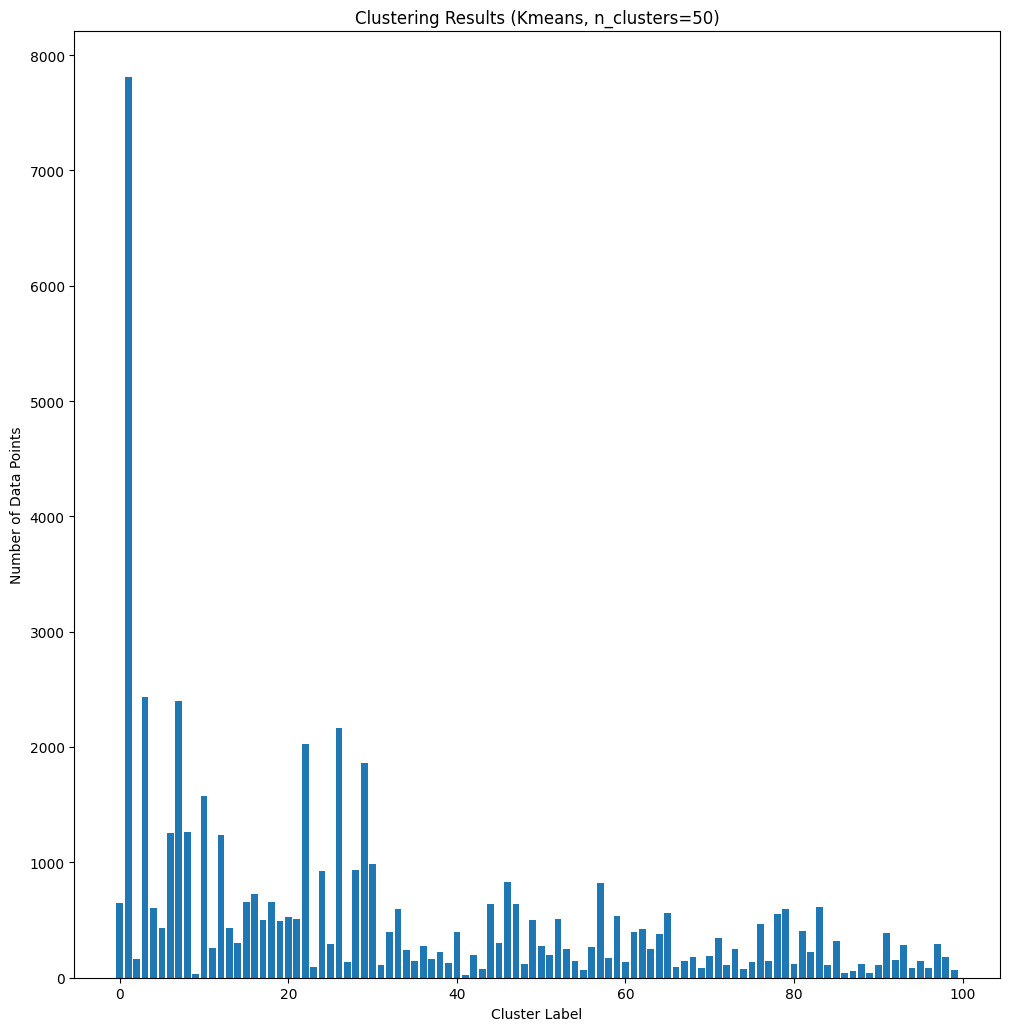

In [207]:
# # visualizing clusters in a bar chart (kmeans)
plt.figure(figsize=(10, 10))
plt.bar(range(0, num_clusters), np.bincount([x for x in X_df['cluster']]), width=0.8)
plt.tight_layout()

plt.title('Clustering Results (Kmeans, n_clusters=50)')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')

plt.show()

# Convert data to trajectories

In [216]:
data_df

subject_id  Creatinine (serum)   
stay_id  time_hour                                             
30002521 2162-05-03 10:00:00    13269859           -0.662381  \
         2164-02-07 10:00:00    13269859           -0.662381   
         2164-02-08 08:00:00    13269859           -0.662381   
30011071 2176-08-18 03:00:00    11885477           -0.662381   
30028516 2179-06-28 18:00:00    15517908           -0.662381   
...                                  ...                 ...   
39861860 2167-09-16 14:00:00    17826428           -0.718349   
         2167-09-16 19:00:00    17826428           -0.718349   
         2167-09-17 07:00:00    17826428           -0.718349   
         2167-09-17 14:00:00    17826428           -0.718349   
39947889 2140-06-02 17:00:00    12638104           -0.718349   

                              Inspired O2 Fraction  Urine output_ApacheIV   
stay_id  time_hour                                                          
30002521 2162-05-03 10:00:00             -2.531506                    0.0  \
         2164-02-07 10:00:00             -2.531506                    0.0   
         2164-02-08 08:00:00             -2.531506                    0.0   
30011071 2176-08-18 03:00:00             -2.531506                    0.0   
30028516 2179-06-28 18:00:00             -2.531506                    0.0   
...                                            ...                    ...   
39861860 2167-09-16 14:00:00             -0.396746                    0.0   
         2167-09-16 19:00:00             -0.396746                    0.0   
         2167-09-17 07:00:00             -0.396746                    0.0   
         2167-09-17 14:00:00             -0.396746                    0.0   
39947889 2140-06-02 17:00:00             -0.396746                    0.0   

                                   ALT       AST   
stay_id  time_hour                                 
30002521 2162-05-03 10:00:00 -0.142368 -0.141890  \
         2164-02-07 10:00:00 -0.142368 -0.141890   
         2164-02-08 08:00:00 -0.142368 -0.141890   
30011071 2176-08-18 03:00:00 -0.142368 -0.141890   
30028516 2179-06-28 18:00:00 -0.142368 -0.141890   
...                                ...       ...   
39861860 2167-09-16 14:00:00 -0.198757 -0.331131   
         2167-09-16 19:00:00 -0.198757 -0.331131   
         2167-09-17 07:00:00 -0.198757 -0.331131   
         2167-09-17 14:00:00 -0.198757 -0.331131   
39947889 2140-06-02 17:00:00 -0.198757 -0.331131   

                              Arterial Blood Pressure mean   
stay_id  time_hour                                           
30002521 2162-05-03 10:00:00                     -0.064513  \
         2164-02-07 10:00:00                     -0.064513   
         2164-02-08 08:00:00                     -0.064513   
30011071 2176-08-18 03:00:00                     -0.064513   
30028516 2179-06-28 18:00:00                     -0.064513   
...                                                    ...   
39861860 2167-09-16 14:00:00                      0.495692   
         2167-09-16 19:00:00                      0.495692   
         2167-09-17 07:00:00                      0.495692   
         2167-09-17 14:00:00                      0.495692   
39947889 2140-06-02 17:00:00                      0.495692   

                              Arterial Blood Pressure diastolic   
stay_id  time_hour                                                
30002521 2162-05-03 10:00:00                           0.136648  \
         2164-02-07 10:00:00                           0.136648   
         2164-02-08 08:00:00                           0.136648   
30011071 2176-08-18 03:00:00                           0.136648   
30028516 2179-06-28 18:00:00                           0.136648   
...                                                         ...   
39861860 2167-09-16 14:00:00                          -0.027339   
         2167-09-16 19:00:00                          -0.027339   
         2167-09-17 07:00:00             

In [227]:
unique_stay_ids = data_df.index.get_level_values('stay_id').unique()
unique_subject_ids = set(data_df['subject_id'])
trajectories = []

for person in unique_subject_ids:
  filtered_df = data_df[data_df['subject_id']==person].drop(columns=['subject_id'])
  unique_stays = filtered_df.index.get_level_values('stay_id').unique()
  for stay_id in unique_stays:
    states, actions = filtered_df.loc[stay_id]['cluster'], filtered_df.loc[stay_id]['action']
    # print(len(states))

    trajectory = []
    if len(states)<2:
      continue
    else:
      for i in range(len(states) - 1):
        trajectory.append((states[i], int(actions[i]), states[i+1] ))

      trajectories.append(T.Trajectory(trajectory))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [228]:
len(trajectories)

1708

In [229]:
terminal_states = []

for traj in trajectories:
  terminal_states.append(traj._t[-1][-1])

terminal_states = list(set(terminal_states))

[(53, 6, 53), (53, 0, 53), (53, 4, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53)]
[(53, 6, 53), (53, 0, 53), (53, 4, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53)]
[(53, 6, 53), (53, 0, 53), (53, 4, 53), (53, 0, 53), (53, 4, 53), (53, 4, 53), (53, 4, 53), (53, 0, 53), (53, 4, 5

In [230]:
terminal_states

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [231]:
y_df.value_counts()

action
4.0     27287
1.0      9194
0.0      7042
2.0      4075
8.0      2410
6.0      1277
5.0       537
9.0       477
12.0      236
3.0       150
7.0        75
13.0       67
10.0       63
11.0       16
14.0        3
Name: count, dtype: int64

In [262]:
# # Uncomment if you want to save all the created dataframes to pickle for later use

# data_non_normalized_df.to_pickle('data_non_normalized_df_pneumonia.pkl')
# data_df.to_pickle('data_df_pneumonia.pkl')
# train_df.to_pickle('train_df_pneumonia.pkl')
# test_df.to_pickle('test_df_pneumonia.pkl')
# X_df.to_pickle('X_df_pneumonia.pkl')
# y_df.to_pickle('y_df_pneumonia.pkl')

# df_traj_test.to_pickle('pneumonia_imputed.pkl')

# Estimating the Transition Dynamics using the MLE

In [235]:
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])
action_bound = 15
action_encoder = OneHotEncoder(sparse=False, categories= [np.arange(action_bound)])

states_onehot = state_encoder.fit_transform(X_df['cluster'].to_numpy().reshape(-1, 1))
actions_onehot = action_encoder.fit_transform(y_df.to_numpy().reshape(-1, 1))

/Users/iliang/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/iliang/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [236]:
smoothing_value = 1

p_transition = np.zeros((num_clusters, num_clusters, action_bound)) + smoothing_value


for traj in trajectories:

  for tran in traj._t:

    p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

In [237]:
p_transition

array([[[0.60080645, 0.75853659, 0.2556391 , ..., 0.01      ,
         0.01      , 0.01      ],
        [0.00403226, 0.00243902, 0.0075188 , ..., 0.01      ,
         0.01      , 0.01      ],
        [0.00403226, 0.00243902, 0.0075188 , ..., 0.01      ,
         0.01      , 0.01      ],
        ...,
        [0.00403226, 0.00243902, 0.0075188 , ..., 0.01      ,
         0.01      , 0.01      ],
        [0.00403226, 0.00243902, 0.0075188 , ..., 0.01      ,
         0.01      , 0.01      ],
        [0.00403226, 0.00243902, 0.0075188 , ..., 0.01      ,
         0.01      , 0.01      ]],

       [[0.00132802, 0.0016835 , 0.00263852, ..., 0.00961538,
         0.01      , 0.01      ],
        [0.8685259 , 0.83333333, 0.73878628, ..., 0.04807692,
         0.01      , 0.01      ],
        [0.00132802, 0.0016835 , 0.00263852, ..., 0.00961538,
         0.01      , 0.01      ],
        ...,
        [0.00132802, 0.0016835 , 0.00263852, ..., 0.00961538,
         0.01      , 0.01      ],
        [0.0

# MCE

In [270]:
"""
Maximum Entropy Inverse Reinforcement Learning and Maximum Causal Entropy
Inverse Reinforcement Learning.

Based on the corresponding paper by B. Ziebart et al. (2008) and the Thesis
by Ziebart (2010).
"""

import numpy as np
from itertools import product


# -- common functions ----------------------------------------------------------

def feature_expectation_from_trajectories(features, trajectories):
    """
    Compute the feature expectation of the given trajectories.

    Simply counts the number of visitations to each feature-instance and
    divides them by the number of trajectories.

    Args:
        features: The feature-matrix (e.g. as numpy array), mapping states
            to features, i.e. a matrix of shape (n_states x n_features).
        trajectories: A list or iterator of `Trajectory` instances.

    Returns:
        The feature-expectation of the provided trajectories as map
        `[state: Integer] -> feature_expectation: Float`.
    """
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:
        for s in t.states():
            fe += features[s, :]

    return fe / len(trajectories)


def initial_probabilities_from_trajectories(n_states, trajectories):
    """
    Compute the probability of a state being a starting state using the
    given trajectories.

    Args:
        n_states: The number of states.
        trajectories: A list or iterator of `Trajectory` instances.

    Returns:
        The probability of a state being a starting-state as map
        `[state: Integer] -> probability: Float`.
    """
    p = np.zeros(n_states)

    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0

    return p / len(trajectories)


def expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps=1e-5):
    """
    Compute the expected state visitation frequency using the given local
    action probabilities.

    This is the forward pass of Algorithm 1 of the Maximum Entropy IRL paper
    by Ziebart et al. (2008). Alternatively, it can also be found as
    Algorithm 9.3 in in Ziebart's thesis (2010).

    It has been slightly adapted for convergence, by forcing transition
    probabilities from terminal stats to be zero.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        p_initial: The probability of a state being an initial state as map
            `[state: Integer] -> probability: Float`.
        terminal: A list of terminal states.
        p_action: Local action probabilities as map
            `[state: Integer, action: Integer] -> probability: Float`
            as returned by `local_action_probabilities`.
        eps: The threshold to be used as convergence criterion. Convergence
            is assumed if the expected state visitation frequency changes
            less than the threshold on all states in a single iteration.

    Returns:
        The expected state visitation frequencies as map
        `[state: Integer] -> svf: Float`.
    """
    n_states, _, n_actions = p_transition.shape

    # 'fix' our transition probabilities to allow for convergence
    # we will _never_ leave any terminal state
    p_transition = np.copy(p_transition)
    p_transition[terminal, :, :] = 0.0

    # set-up transition matrices for each action
    p_transition = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # actual forward-computation of state expectations
    d = np.zeros(n_states)

    delta = np.inf
    while delta > eps:
        d_ = [p_transition[a].T.dot(p_action[:, a] * d) for a in range(n_actions)]
        d_ = p_initial + np.array(d_).sum(axis=0)

        delta, d = np.max(np.abs(d_ - d)), d_

    return d


# -- plain maximum entropy (Ziebart et al. 2008) -------------------------------

def local_action_probabilities(p_transition, terminal, reward):
    """
    Compute the local action probabilities (policy) required for the edge
    frequency calculation for maximum entropy reinfocement learning.

    This is the backward pass of Algorithm 1 of the Maximum Entropy IRL
    paper by Ziebart et al. (2008).

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        terminal: A set/list of terminal states.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.

    Returns:
        The local action probabilities (policy) as map
        `[state: Integer, action: Integer] -> probability: Float`
    """
    n_states, _, n_actions = p_transition.shape

    er = np.exp(reward)
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # initialize at terminal states
    zs = np.zeros(n_states)
    zs[terminal] = 1.0

    # perform backward pass
    # This does not converge, instead we iterate a fixed number of steps. The
    # number of steps is chosen to reflect the maximum steps required to
    # guarantee propagation from any state to any other state and back in an
    # arbitrary MDP defined by p_transition.
    for _ in range(2 * n_states):
        za = np.array([er * p[a].dot(zs) for a in range(n_actions)]).T
        zs = za.sum(axis=1)

    # compute local action probabilities
    return za / zs[:, None]


def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    """
    Compute the expected state visitation frequency for maximum entropy IRL.

    This is an implementation of Algorithm 1 of the Maximum Entropy IRL
    paper by Ziebart et al. (2008).

    This function combines the backward pass implemented in
    `local_action_probabilities` with the forward pass implemented in
    `expected_svf_from_policy`.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        p_initial: The probability of a state being an initial state as map
            `[state: Integer] -> probability: Float`.
        terminal: A list of terminal states.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        eps: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.

    Returns:
        The expected state visitation frequencies as map
        `[state: Integer] -> svf: Float`.
    """
    p_action = local_action_probabilities(p_transition, terminal, reward)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps)


def irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4, eps_esvf=1e-5):
    """
    Compute the reward signal given the demonstration trajectories using the
    maximum entropy inverse reinforcement learning algorithm proposed in the
    corresponding paper by Ziebart et al. (2008).

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        features: The feature-matrix (e.g. as numpy array), mapping states
            to features, i.e. a matrix of shape (n_states x n_features).
        terminal: A list of terminal states.
        trajectories: A list of `Trajectory` instances representing the
            expert demonstrations.
        optim: The `Optimizer` instance to use for gradient-based
            optimization.
        init: The `Initializer` to use for initialization of the reward
            function parameters.
        eps: The threshold to be used as convergence criterion for the
            reward parameters. Convergence is assumed if all changes in the
            scalar parameters are less than the threshold in a single
            iteration.
        eps_svf: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.

    Returns:
        The reward per state as table `[state: Integer] -> reward: Float`.
    """
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute static properties from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # basic gradient descent
    theta = init(n_features)
    delta = np.inf

    optim.reset(theta)
    count = 0
    while delta > eps:
        if count > 10000:
            print('diverges: max ent')
            break
        theta_old = theta.copy()

        # compute per-state reward
        reward = features.dot(theta)

        # compute the gradient
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward, eps_esvf)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))
        count += 1

    # re-compute per-state reward and return
    return features.dot(theta)


# -- maximum causal entropy (Ziebart 2010) -------------------------------------

def softmax(x1, x2):
    """
    Computes a soft maximum of both arguments.

    In case `x1` and `x2` are arrays, computes the element-wise softmax.

    Args:
        x1: Scalar or ndarray.
        x2: Scalar or ndarray.

    Returns:
        The soft maximum of the given arguments, either scalar or ndarray,
        depending on the input.
    """
    x_max = np.maximum(x1, x2)
    x_min = np.minimum(x1, x2)
    return x_max + np.log(1.0 + np.exp(x_min - x_max))


def local_causal_action_probabilities(p_transition, terminal, reward, discount, eps=1e-5):
    """
    Compute the local action probabilities (policy) required for the edge
    frequency calculation for maximum causal entropy reinfocement learning.

    This is Algorithm 9.1 from Ziebart's thesis (2010) combined with
    discounting for convergence reasons as proposed in the same thesis.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        terminal: Either the terminal reward function or a collection of
            terminal states. Iff `len(terminal)` is equal to the number of
            states, it is assumed to contain the terminal reward function
            (phi) as specified in Ziebart's thesis. Otherwise `terminal` is
            assumed to be a collection of terminal states from which the
            terminal reward function will be derived.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        discount: A discounting factor as Float.
        eps: The threshold to be used as convergence criterion for the state
            partition function. Convergence is assumed if the state
            partition function changes less than the threshold on all states
            in a single iteration.

    Returns:
        The local action probabilities (policy) as map
        `[state: Integer, action: Integer] -> probability: Float`
    """
    n_states, _, n_actions = p_transition.shape

    # set up terminal reward function
    if len(terminal) == n_states:
        reward_terminal = np.array(terminal, dtype=float)
    else:
        reward_terminal = -np.inf * np.ones(n_states)
        reward_terminal[terminal] = 0.0

    # set up transition probability matrices
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # compute state log partition V and state-action log partition Q
    v = -1e200 * np.ones(n_states)  # np.dot doesn't behave with -np.inf

    delta = np.inf
    while delta > eps:
        v_old = v

        q = np.array([reward + discount * p[a].dot(v_old) for a in range(n_actions)]).T

        v = reward_terminal
        for a in range(n_actions):
            v = softmax(v, q[:, a])

        # for some reason numpy chooses an array of objects after reduction, force floats here
        v = np.array(v, dtype=float)

        delta = np.max(np.abs(v - v_old))

    # compute and return policy
    return np.exp(q - v[:, None])


def compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                eps_lap=1e-5, eps_svf=1e-5):
    """
    Compute the expected state visitation frequency for maximum causal
    entropy IRL.

    This is a combination of Algorithm 9.1 and 9.3 of Ziebart's thesis
    (2010). See `local_causal_action_probabilities` and
    `expected_svf_from_policy` for more details.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        p_initial: The probability of a state being an initial state as map
            `[state: Integer] -> probability: Float`.
        terminal: Either the terminal reward function or a collection of
            terminal states. Iff `len(terminal)` is equal to the number of
            states, it is assumed to contain the terminal reward function
            (phi) as specified in Ziebart's thesis. Otherwise `terminal` is
            assumed to be a collection of terminal states from which the
            terminal reward function will be derived.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        discount: A discounting factor as Float.
        eps_lap: The threshold to be used as convergence criterion for the
            state partition function. Convergence is assumed if the state
            partition function changes less than the threshold on all states
            in a single iteration.
        eps_svf: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.
    """
    p_action = local_causal_action_probabilities(p_transition, terminal, reward, discount, eps_lap)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps_svf)


def irl_causal(p_transition, features, terminal, trajectories, optim, init, discount,
               eps=1e-4, eps_svf=1e-5, eps_lap=1e-5):
    """
    Compute the reward signal given the demonstration trajectories using the
    maximum causal entropy inverse reinforcement learning algorithm proposed
    Ziebart's thesis (2010).

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        features: The feature-matrix (e.g. as numpy array), mapping states
            to features, i.e. a matrix of shape (n_states x n_features).
        terminal: Either the terminal reward function or a collection of
            terminal states. Iff `len(terminal)` is equal to the number of
            states, it is assumed to contain the terminal reward function
            (phi) as specified in Ziebart's thesis. Otherwise `terminal` is
            assumed to be a collection of terminal states from which the
            terminal reward function will be derived.
        trajectories: A list of `Trajectory` instances representing the
            expert demonstrations.
        optim: The `Optimizer` instance to use for gradient-based
            optimization.
        init: The `Initializer` to use for initialization of the reward
            function parameters.
        discount: A discounting factor for the log partition functions as
            Float.
        eps: The threshold to be used as convergence criterion for the
            reward parameters. Convergence is assumed if all changes in the
            scalar parameters are less than the threshold in a single
            iteration.
        eps_lap: The threshold to be used as convergence criterion for the
            state partition function. Convergence is assumed if the state
            partition function changes less than the threshold on all states
            in a single iteration.
        eps_svf: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.
    """
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute static properties from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # basic gradient descent
    theta = init(n_features)
    delta = np.inf

    optim.reset(theta)

    count = 0
    while delta > eps:
        if count > 10000:
            print('diverges: max causal')
            break
        theta_old = theta.copy()

        # compute per-state reward
        reward = features.dot(theta)

        # compute the gradient
        e_svf = compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                            eps_lap, eps_svf)

        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))
        
        if count % 50 == 0:
            print(delta)

        count += 1

    # re-compute per-state reward and return
    return features.dot(theta)


In [271]:
smoothing_value = 1
discount = 0.9

In [282]:
# set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
features = state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.07))

# actually do some inverse reinforcement learning
# reward_maxent = irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

reward_maxent_causal = irl_causal(p_transition, features, terminal_states, trajectories, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

0.3744776533801033
0.02617113021437323
0.016423390744341404
0.012484211954501667
0.010271953600557104
0.008828003267783657
0.007799441052705802
0.007023463477454861
0.006413728986277789
0.0059198464573295695
0.00551027016553185
0.005164162332945921
0.004867160570114493
0.004609017892162726
0.004382211295117955
0.004181082865851948
0.004001288843452855
0.003839434480882531
0.0036928251420231817
0.003559292425968863
0.003437070060892111
0.003324703616904401
0.00322098369569801
0.0031248957318847914
0.0030355817522202955
0.0029523108775055817
0.002874456307502271
0.002801477175555789
0.0027329041047412517
0.002668327608247978
0.002607388697443369
0.0025497712194670896
0.002495195561541763
0.0024434134441069233
0.0023942035877517753
0.0023473680865677693
0.002302729356159716
0.0022601275521871855
0.0022194183763630804
0.0021804712032906792
0.002143167474322638
0.002107399314811076
0.0020730683390315363
0.002040084613589954
0.002008365755086672
0.001977836142115663
0.001948426224862132
0.00

In [283]:
reward_maxent_causal
# lr=0.07 with 1e-3 threshold

array([ 1.26164367, 19.24034357,  1.05720357,  2.48773598,  1.24825568,
        1.17353868,  1.59235133,  2.45478147,  1.58992638,  1.00995546,
        1.81189585,  1.09450158,  1.59660389,  1.17309164,  1.1155522 ,
        1.27663364,  1.30964254,  1.19930377,  1.27517524,  1.19474301,
        1.21911426,  1.20296491,  2.13038448,  1.03527988,  1.41711491,
        1.10329402,  2.27120823,  1.04678238,  1.42144097,  2.00974555,
        1.44327015,  1.03212907,  1.14526853,  1.2312511 ,  1.09200235,
        1.052782  ,  1.09993622,  1.0628579 ,  1.08412571,  1.04359657,
        1.15271068,  1.00381736,  1.07262146,  1.02195504,  1.26549511,
        1.11215709,  1.36569738,  1.25684584,  1.03527988,  1.20250666,
        1.10203365,  1.06935702,  1.20067539,  1.09742458,  1.04957794,
        1.01962147,  1.09575334,  1.36361759,  1.05680085,  1.2219044 ,
        1.04439211,  1.15139386,  1.17130516,  1.0928348 ,  1.13354727,
        1.22797165,  1.03095   ,  1.04997791,  1.06326293,  1.02

In [277]:
reward_maxent_causal
# lr=0.05 with 1e-3 threshold

array([1.14880133, 5.84108183, 1.03375894, 1.72281696, 1.14150966,
       1.10022147, 1.32004466, 1.70915898, 1.31884445, 1.00593013,
       1.42583412, 1.0553746 , 1.32214765, 1.0999713 , 1.06744313,
       1.1569286 , 1.17469095, 1.11457567, 1.15613959, 1.11204392,
       1.12552808, 1.11660523, 1.57051804, 1.02090977, 1.23130997,
       1.06042667, 1.63167995, 1.02766475, 1.23355209, 1.51681396,
       1.24482408, 1.01905415, 1.08432466, 1.13220261, 1.05393557,
       1.03117623, 1.05849923, 1.03705538, 1.0493916 , 1.02579686,
       1.08852471, 1.00227667, 1.04273089, 1.01304665, 1.15089321,
       1.06550293, 1.20444636, 1.14619183, 1.02090977, 1.11635133,
       1.05970347, 1.04083561, 1.11533633, 1.05705594, 1.02930195,
       1.01166534, 1.05609485, 1.20335126, 1.03352388, 1.12706485,
       1.02626351, 1.08778235, 1.09897118, 1.05441503, 1.07768728,
       1.13040174, 1.01835916, 1.02953605, 1.03729124, 1.01466056,
       1.04154594, 1.07255298, 1.02090977, 1.0532168 , 1.01489

# Edited IRL_causal function for epoch reward value extraction

In [291]:
"""
Maximum Entropy Inverse Reinforcement Learning and Maximum Causal Entropy
Inverse Reinforcement Learning.

Based on the corresponding paper by B. Ziebart et al. (2008) and the Thesis
by Ziebart (2010).
"""

import numpy as np
from itertools import product


# -- common functions ----------------------------------------------------------

def feature_expectation_from_trajectories(features, trajectories):
    """
    Compute the feature expectation of the given trajectories.

    Simply counts the number of visitations to each feature-instance and
    divides them by the number of trajectories.

    Args:
        features: The feature-matrix (e.g. as numpy array), mapping states
            to features, i.e. a matrix of shape (n_states x n_features).
        trajectories: A list or iterator of `Trajectory` instances.

    Returns:
        The feature-expectation of the provided trajectories as map
        `[state: Integer] -> feature_expectation: Float`.
    """
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:
        for s in t.states():
            fe += features[s, :]

    return fe / len(trajectories)


def initial_probabilities_from_trajectories(n_states, trajectories):
    """
    Compute the probability of a state being a starting state using the
    given trajectories.

    Args:
        n_states: The number of states.
        trajectories: A list or iterator of `Trajectory` instances.

    Returns:
        The probability of a state being a starting-state as map
        `[state: Integer] -> probability: Float`.
    """
    p = np.zeros(n_states)

    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0

    return p / len(trajectories)


def expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps=1e-5):
    """
    Compute the expected state visitation frequency using the given local
    action probabilities.

    This is the forward pass of Algorithm 1 of the Maximum Entropy IRL paper
    by Ziebart et al. (2008). Alternatively, it can also be found as
    Algorithm 9.3 in in Ziebart's thesis (2010).

    It has been slightly adapted for convergence, by forcing transition
    probabilities from terminal stats to be zero.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        p_initial: The probability of a state being an initial state as map
            `[state: Integer] -> probability: Float`.
        terminal: A list of terminal states.
        p_action: Local action probabilities as map
            `[state: Integer, action: Integer] -> probability: Float`
            as returned by `local_action_probabilities`.
        eps: The threshold to be used as convergence criterion. Convergence
            is assumed if the expected state visitation frequency changes
            less than the threshold on all states in a single iteration.

    Returns:
        The expected state visitation frequencies as map
        `[state: Integer] -> svf: Float`.
    """
    n_states, _, n_actions = p_transition.shape

    # 'fix' our transition probabilities to allow for convergence
    # we will _never_ leave any terminal state
    p_transition = np.copy(p_transition)
    p_transition[terminal, :, :] = 0.0

    # set-up transition matrices for each action
    p_transition = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # actual forward-computation of state expectations
    d = np.zeros(n_states)

    delta = np.inf
    while delta > eps:
        d_ = [p_transition[a].T.dot(p_action[:, a] * d) for a in range(n_actions)]
        d_ = p_initial + np.array(d_).sum(axis=0)

        delta, d = np.max(np.abs(d_ - d)), d_

    return d


# -- plain maximum entropy (Ziebart et al. 2008) -------------------------------

def local_action_probabilities(p_transition, terminal, reward):
    """
    Compute the local action probabilities (policy) required for the edge
    frequency calculation for maximum entropy reinfocement learning.

    This is the backward pass of Algorithm 1 of the Maximum Entropy IRL
    paper by Ziebart et al. (2008).

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        terminal: A set/list of terminal states.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.

    Returns:
        The local action probabilities (policy) as map
        `[state: Integer, action: Integer] -> probability: Float`
    """
    n_states, _, n_actions = p_transition.shape

    er = np.exp(reward)
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # initialize at terminal states
    zs = np.zeros(n_states)
    zs[terminal] = 1.0

    # perform backward pass
    # This does not converge, instead we iterate a fixed number of steps. The
    # number of steps is chosen to reflect the maximum steps required to
    # guarantee propagation from any state to any other state and back in an
    # arbitrary MDP defined by p_transition.
    for _ in range(2 * n_states):
        za = np.array([er * p[a].dot(zs) for a in range(n_actions)]).T
        zs = za.sum(axis=1)

    # compute local action probabilities
    return za / zs[:, None]


def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    """
    Compute the expected state visitation frequency for maximum entropy IRL.

    This is an implementation of Algorithm 1 of the Maximum Entropy IRL
    paper by Ziebart et al. (2008).

    This function combines the backward pass implemented in
    `local_action_probabilities` with the forward pass implemented in
    `expected_svf_from_policy`.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        p_initial: The probability of a state being an initial state as map
            `[state: Integer] -> probability: Float`.
        terminal: A list of terminal states.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        eps: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.

    Returns:
        The expected state visitation frequencies as map
        `[state: Integer] -> svf: Float`.
    """
    p_action = local_action_probabilities(p_transition, terminal, reward)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps)


def irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4, eps_esvf=1e-5):
    """
    Compute the reward signal given the demonstration trajectories using the
    maximum entropy inverse reinforcement learning algorithm proposed in the
    corresponding paper by Ziebart et al. (2008).

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        features: The feature-matrix (e.g. as numpy array), mapping states
            to features, i.e. a matrix of shape (n_states x n_features).
        terminal: A list of terminal states.
        trajectories: A list of `Trajectory` instances representing the
            expert demonstrations.
        optim: The `Optimizer` instance to use for gradient-based
            optimization.
        init: The `Initializer` to use for initialization of the reward
            function parameters.
        eps: The threshold to be used as convergence criterion for the
            reward parameters. Convergence is assumed if all changes in the
            scalar parameters are less than the threshold in a single
            iteration.
        eps_svf: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.

    Returns:
        The reward per state as table `[state: Integer] -> reward: Float`.
    """
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute static properties from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # basic gradient descent
    theta = init(n_features)
    delta = np.inf

    optim.reset(theta)
    while delta > eps:
        theta_old = theta.copy()

        # compute per-state reward
        reward = features.dot(theta)

        # compute the gradient
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward, eps_esvf)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))

    # re-compute per-state reward and return
    return features.dot(theta)


# -- maximum causal entropy (Ziebart 2010) -------------------------------------

def softmax(x1, x2):
    """
    Computes a soft maximum of both arguments.

    In case `x1` and `x2` are arrays, computes the element-wise softmax.

    Args:
        x1: Scalar or ndarray.
        x2: Scalar or ndarray.

    Returns:
        The soft maximum of the given arguments, either scalar or ndarray,
        depending on the input.
    """
    x_max = np.maximum(x1, x2)
    x_min = np.minimum(x1, x2)
    return x_max + np.log(1.0 + np.exp(x_min - x_max))


def local_causal_action_probabilities(p_transition, terminal, reward, discount, eps=1e-5):
    """
    Compute the local action probabilities (policy) required for the edge
    frequency calculation for maximum causal entropy reinfocement learning.

    This is Algorithm 9.1 from Ziebart's thesis (2010) combined with
    discounting for convergence reasons as proposed in the same thesis.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        terminal: Either the terminal reward function or a collection of
            terminal states. Iff `len(terminal)` is equal to the number of
            states, it is assumed to contain the terminal reward function
            (phi) as specified in Ziebart's thesis. Otherwise `terminal` is
            assumed to be a collection of terminal states from which the
            terminal reward function will be derived.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        discount: A discounting factor as Float.
        eps: The threshold to be used as convergence criterion for the state
            partition function. Convergence is assumed if the state
            partition function changes less than the threshold on all states
            in a single iteration.

    Returns:
        The local action probabilities (policy) as map
        `[state: Integer, action: Integer] -> probability: Float`
    """
    n_states, _, n_actions = p_transition.shape

    # set up terminal reward function
    if len(terminal) == n_states:
        reward_terminal = np.array(terminal, dtype=float)
    else:
        reward_terminal = -np.inf * np.ones(n_states)
        reward_terminal[terminal] = 0.0

    # set up transition probability matrices
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]

    # compute state log partition V and state-action log partition Q
    v = -1e200 * np.ones(n_states)  # np.dot doesn't behave with -np.inf

    delta = np.inf
    while delta > eps:
        v_old = v

        q = np.array([reward + discount * p[a].dot(v_old) for a in range(n_actions)]).T

        v = reward_terminal
        for a in range(n_actions):
            v = softmax(v, q[:, a])

        # for some reason numpy chooses an array of objects after reduction, force floats here
        v = np.array(v, dtype=float)

        delta = np.max(np.abs(v - v_old))

    # compute and return policy
    return np.exp(q - v[:, None])


def compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                eps_lap=1e-5, eps_svf=1e-5):
    """
    Compute the expected state visitation frequency for maximum causal
    entropy IRL.

    This is a combination of Algorithm 9.1 and 9.3 of Ziebart's thesis
    (2010). See `local_causal_action_probabilities` and
    `expected_svf_from_policy` for more details.

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        p_initial: The probability of a state being an initial state as map
            `[state: Integer] -> probability: Float`.
        terminal: Either the terminal reward function or a collection of
            terminal states. Iff `len(terminal)` is equal to the number of
            states, it is assumed to contain the terminal reward function
            (phi) as specified in Ziebart's thesis. Otherwise `terminal` is
            assumed to be a collection of terminal states from which the
            terminal reward function will be derived.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        discount: A discounting factor as Float.
        eps_lap: The threshold to be used as convergence criterion for the
            state partition function. Convergence is assumed if the state
            partition function changes less than the threshold on all states
            in a single iteration.
        eps_svf: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.
    """
    p_action = local_causal_action_probabilities(p_transition, terminal, reward, discount, eps_lap)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps_svf)


def irl_causal(X_df, p_transition, features, terminal, trajectories, optim, init, discount,eps=1e-4, eps_svf=1e-5, eps_lap=1e-5):
    """
    Compute the reward signal given the demonstration trajectories using the
    maximum causal entropy inverse reinforcement learning algorithm proposed
    Ziebart's thesis (2010).

    Args:
        p_transition: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        features: The feature-matrix (e.g. as numpy array), mapping states
            to features, i.e. a matrix of shape (n_states x n_features).
        terminal: Either the terminal reward function or a collection of
            terminal states. Iff `len(terminal)` is equal to the number of
            states, it is assumed to contain the terminal reward function
            (phi) as specified in Ziebart's thesis. Otherwise `terminal` is
            assumed to be a collection of terminal states from which the
            terminal reward function will be derived.
        trajectories: A list of `Trajectory` instances representing the
            expert demonstrations.
        optim: The `Optimizer` instance to use for gradient-based
            optimization.
        init: The `Initializer` to use for initialization of the reward
            function parameters.
        discount: A discounting factor for the log partition functions as
            Float.
        eps: The threshold to be used as convergence criterion for the
            reward parameters. Convergence is assumed if all changes in the
            scalar parameters are less than the threshold in a single
            iteration.
        eps_lap: The threshold to be used as convergence criterion for the
            state partition function. Convergence is assumed if the state
            partition function changes less than the threshold on all states
            in a single iteration.
        eps_svf: The threshold to be used as convergence criterion for the
            expected state-visitation frequency. Convergence is assumed if
            the expected state visitation frequency changes less than the
            threshold on all states in a single iteration.
    """
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute static properties from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # basic gradient descent
    theta = init(n_features)
    delta = np.inf

    # input data
    epochs_infos = []

    optim.reset(theta)
    count = 0
    while delta > eps:
        if count > 10000:
            print("does not converge")
            break
        
        theta_old = theta.copy()

        # compute per-state reward
        reward = features.dot(theta)

        epochs_infos.append(reward.tolist())

        # compute the gradient
        e_svf = compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                            eps_lap, eps_svf)

        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))
        count +=1

    # re-compute per-state reward and return
    final_reward =features.dot(theta)
    epochs_infos.append(final_reward.tolist())

    return epochs_infos, final_reward

def update(reward_list, X_df):

    rankings = list(np.argsort(reward_list))
    # lowest to highest
    all_cluster_info = {}
    for i in range(len(reward_list)):
        # reward_maxent_causal[i] is the reward value
        cluster_id = i+1
        reward_value = reward_list[i]
        data = X_df[(X_df['cluster'] == i+1)]
        all_cluster_info[cluster_id] = data.mean().to_dict()
        all_cluster_info[cluster_id]['reward_value'] = reward_value
        # note: rankings are 0-indexed with the unhealthiest first (lowest)
        all_cluster_info[cluster_id]['ranking'] = rankings.index(i)
    # add to history
    return all_cluster_info

def extract_values(discount_val, features, cluster_algo, smooth_val, learning_rate=0.2, data=''):
  # choose our parameter initialization strategy:
  #   initialize parameters with constant
  init = O.Constant(1.0)

  # choose our optimization strategy:
  #   we select exponentiated stochastic gradient descent with linear learning-rate decay
  optim = O.ExpSga(lr=O.linear_decay(lr0=learning_rate))

  # actually do some inverse reinforcement learning
  # reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

  # send in the X_df dataframe
  epochs_infos, final_reward = irl_causal(data_non_normalized_df, p_transition, features, terminal_states, trajectories, optim, init, discount_val, eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

  if data != '':
    file_name = data+'_mce_' + cluster_algo + str(discount_val)+'_smooth'+str(smooth_val)+'_lr'+str(learning_rate)+'.json'
  else:
    file_name = '_mce_' + cluster_algo + str(discount_val)+'_smooth'+str(smooth_val)+'.json'

  final_cluster_info = update(final_reward, data_non_normalized_df)
  print("----")
  print(final_cluster_info)
  print("----")
  # print(epochs_infos)
  print("---")
  print(np.array(epochs_infos).shape)
  with open(file_name, 'w') as m:
    json.dump(epochs_infos, m)

  return epochs_infos

In [294]:
smoothing_val_exp = 1
discount_exp = 0.001

epoch_reward_values = extract_values(discount_exp, features, 'kmeans', smoothing_val_exp, learning_rate=0.1, data='pneumonia')

does not converge
----
{1: {'subject_id': 12468050.984772872, 'Creatinine (serum)': 2.891823416506718, 'Inspired O2 Fraction': 48.72680742162508, 'Urine output_ApacheIV': 80.0, 'ALT': 18.92514395393474, 'AST': 26.784516954574535, 'Arterial Blood Pressure mean': 81.52156110044785, 'Arterial Blood Pressure diastolic': 61.284580934101086, 'Arterial Blood Pressure systolic': 123.07152911068458, 'GcsScore_ApacheIV': 11.0, 'Arterial O2 pressure': 113.58144593730006, 'Heart Rate': 81.93115802943058, 'Temperature Celsius': 38.97548304542547, 'Respiratory Rate': 17.274984005118363, 'O2 saturation pulseoxymetry': 95.65182341650672, 'action': 3.506589891234805, 'cluster': 1.0, 'reward_value': 1.4184446146634244, 'ranking': 80}, 2: {'subject_id': 18085369.98136646, 'Creatinine (serum)': 2.340372670807453, 'Inspired O2 Fraction': 44.78260869565217, 'Urine output_ApacheIV': 80.0, 'ALT': 24.63975155279503, 'AST': 31.37888198757764, 'Arterial Blood Pressure mean': 72.43478260869566, 'Arterial Blood Pr